In [33]:
import pathlib
import rasterio
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
# Written Utils Functions
from Utils.utils import build_embedding_model, compute_image_embeddings
from Utils.utils import compute_tabular_features
from Utils.utils import compute_multi_embeddings, construct_filename
from Utils.utils import build_autoencoder_model, compute_ae_embeddings, ConvAE1C
# Writtent Model Functions
from Utils.computation import compute_pca_components
from Utils.computation import estimate_treatment_effect_tabular 
from Utils.computation import estimate_treatment_effect_with_embeddings
from Utils.computation import evaluate_ite, get_train_test_indices


In [34]:
# Collect file paths
SYNTH_DIR = pathlib.Path('/home/sm79829/Hetwet/Data/Synthetic_5')
SYNTH_DIR_2 = pathlib.Path('/home/sm79829/Hetwet/Data/Synthetic')

folders = {
    'wet': SYNTH_DIR / 'Treatment',
    'dem': SYNTH_DIR_2 / 'DEM',
    'cap': SYNTH_DIR_2 / 'CAPITAL_1996',
    'outcome_pre': SYNTH_DIR / 'Outcome',
    'outcome_post': SYNTH_DIR / 'Outcome_Post',
    'ite_direct': SYNTH_DIR / 'ITE_Direct',
    'ite_indirect': SYNTH_DIR / 'ITE_Indirect',
    'ite_total': SYNTH_DIR / 'ITE_Total',
    'theta_directXout': SYNTH_DIR / 'Theta_DirectXOutgoing',
    'theta_outgoing': SYNTH_DIR / 'Theta_Outgoing',
    'theta': SYNTH_DIR / 'Theta'

}


scene_ids = [str(i) for i in range(1, 3566)]

In [35]:
# Tabular features
tab_df = compute_tabular_features(folders, scene_ids)
tab_df.head()

/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Saved features to: /home/sm79829/Hetwet/ImageTRT/Model/features.csv


,scene_id,dem_mean,dem_std,cap_mean,cap_std,wet_mean,wet_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,...,ite_indirect_mean,ite_indirect_std,ite_total_mean,ite_total_std,theta_directXout_mean,theta_directXout_std,theta_outgoing_mean,theta_outgoing_std,theta_mean,theta_std
0,1,2.011171,1.077544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.376258,1.103501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3.807717,0.715921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.105153,0.670853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3.012371,0.481668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
tab_df.describe()

,dem_mean,dem_std,cap_mean,cap_std,wet_mean,wet_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,outcome_post_std,...,ite_indirect_mean,ite_indirect_std,ite_total_mean,ite_total_std,theta_directXout_mean,theta_directXout_std,theta_outgoing_mean,theta_outgoing_std,theta_mean,theta_std
count,3.100000e+03,3100.000000,2.263000e+03,2263.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,...,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000
mean,-2.616998e-12,0.207664,1.699756e-10,0.467900,0.488910,0.114444,0.138751,0.122257,0.322422,0.140003,...,0.014583,0.002557,0.317952,0.050974,0.049384,0.000993,0.029702,0.000704,0.601956,0.008447
std,9.565231e-01,0.205543,1.977197e-01,0.861581,0.459105,0.161586,0.091470,0.071489,0.303519,0.086932,...,0.013900,0.003648,0.298944,0.079597,0.000078,0.000297,0.001106,0.000478,0.022053,0.010669
min,-9.874524e-01,0.008042,-1.034196e-01,0.055132,0.000000,0.000000,-0.101542,0.065840,-0.034204,0.066897,...,0.000000,0.000000,0.000000,0.000000,0.049128,0.000254,0.025896,0.000171,0.526365,0.000519
25%,-8.059669e-01,0.048691,-9.570200e-02,0.075681,0.001640,0.006766,0.087005,0.097164,0.008769,0.096005,...,0.000033,0.000133,0.001172,0.001180,0.049339,0.000790,0.028968,0.000493,0.587659,0.002824
50%,-2.506089e-01,0.130152,-7.508054e-02,0.136465,0.419952,0.014083,0.132564,0.104396,0.267124,0.104862,...,0.011526,0.000886,0.269746,0.008467,0.049386,0.000994,0.029822,0.000623,0.604182,0.005564
75%,5.988298e-01,0.320810,-2.250990e-03,0.357029,0.999939,0.182918,0.171696,0.115472,0.642750,0.152331,...,0.029946,0.002788,0.645417,0.062091,0.049428,0.001211,0.030459,0.000754,0.616976,0.009739
max,3.807717e+00,1.226516,1.739482e+00,8.535286,1.000000,0.500000,0.775452,1.151665,1.153542,1.305825,...,0.033993,0.014176,0.729332,0.301344,0.049701,0.001909,0.034422,0.007274,0.695351,0.142856


## SINGLE LAYER EMBEDDINGS

In [5]:
# Embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_embedding_model(
    device=device,
    model_type='resnet50', 
    conv_layer=4             
)

# Compute image embeddings for each variable
# for var in folders:
#     _ = compute_image_embeddings(
#         folders=folders,
#         scene_ids=scene_ids,
#         var=var,
#         model=model,
#         device=device,
#         img_size=256,
#     )

# Compute image embeddings for only wetland
var = 'wet'
_ = compute_image_embeddings(
    folders=folders,
    scene_ids=scene_ids,
    var=var,
    model=model,
    device=device,
    img_size=256,
)

/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Embedding wet scenes:   0%|          | 0/3565 [00:00<?, ?it/s]/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

Missing file for var='wet', scene='1': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1.tiff
Missing file for var='wet', scene='2': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2.tiff
Missing file for var='wet', scene='3': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3.tiff
Missing file for var='wet', scene='4': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_4.tiff
Missing file for var='wet', scene='5': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_5.tiff
Missing file for var='wet', scene='6': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_6.tiff
Missing file for var='wet', scene='7': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_7.tiff
Missing file for var='wet', scene='8': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_8.tiff
Missing file for var='wet', scene='9': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_9.tiff
Missing fi

Embedding wet scenes:   4%|▎         | 132/3565 [00:00<00:05, 578.14it/s]

Missing file for var='wet', scene='75': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_75.tiff
Missing file for var='wet', scene='76': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_76.tiff
Missing file for var='wet', scene='77': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_77.tiff
Missing file for var='wet', scene='78': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_78.tiff
Missing file for var='wet', scene='79': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_79.tiff
Missing file for var='wet', scene='80': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_80.tiff
Missing file for var='wet', scene='81': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_81.tiff
Missing file for var='wet', scene='82': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_82.tiff
Missing file for var='wet', scene='83': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_

Embedding wet scenes:   6%|▋         | 227/3565 [00:00<00:16, 204.77it/s]

Missing file for var='wet', scene='190': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_190.tiff
Missing file for var='wet', scene='191': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_191.tiff
Missing file for var='wet', scene='192': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_192.tiff
Missing file for var='wet', scene='193': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_193.tiff
Missing file for var='wet', scene='194': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_194.tiff
Missing file for var='wet', scene='195': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_195.tiff
Missing file for var='wet', scene='196': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_196.tiff
Missing file for var='wet', scene='197': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_197.tiff
Missing file for var='wet', scene='198': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment

Embedding wet scenes:   9%|▊         | 305/3565 [00:02<00:31, 102.43it/s]

Missing file for var='wet', scene='268': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_268.tiff
Missing file for var='wet', scene='269': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_269.tiff
Missing file for var='wet', scene='270': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_270.tiff
Missing file for var='wet', scene='271': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_271.tiff
Missing file for var='wet', scene='272': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_272.tiff
Missing file for var='wet', scene='273': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_273.tiff
Missing file for var='wet', scene='274': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_274.tiff
Missing file for var='wet', scene='275': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_275.tiff
Missing file for var='wet', scene='276': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment

Embedding wet scenes:   9%|▉         | 323/3565 [00:02<00:40, 79.27it/s] 

Missing file for var='wet', scene='313': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_313.tiff
Missing file for var='wet', scene='314': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_314.tiff
Missing file for var='wet', scene='315': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_315.tiff
Missing file for var='wet', scene='316': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_316.tiff
Missing file for var='wet', scene='317': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_317.tiff
Missing file for var='wet', scene='318': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_318.tiff
Missing file for var='wet', scene='319': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_319.tiff
Missing file for var='wet', scene='320': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_320.tiff
Missing file for var='wet', scene='321': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment

Embedding wet scenes:  11%|█         | 381/3565 [00:04<00:52, 61.03it/s]

Missing file for var='wet', scene='348': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_348.tiff
Missing file for var='wet', scene='349': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_349.tiff
Missing file for var='wet', scene='350': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_350.tiff
Missing file for var='wet', scene='351': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_351.tiff
Missing file for var='wet', scene='352': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_352.tiff
Missing file for var='wet', scene='353': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_353.tiff
Missing file for var='wet', scene='354': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_354.tiff
Missing file for var='wet', scene='355': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_355.tiff
Missing file for var='wet', scene='356': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment

Embedding wet scenes:  11%|█         | 395/3565 [00:04<01:10, 44.75it/s]

Missing file for var='wet', scene='392': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_392.tiff


Embedding wet scenes:  12%|█▏        | 436/3565 [00:06<01:33, 33.34it/s]

Missing file for var='wet', scene='427': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_427.tiff
Missing file for var='wet', scene='428': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_428.tiff
Missing file for var='wet', scene='429': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_429.tiff
Missing file for var='wet', scene='430': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_430.tiff
Missing file for var='wet', scene='431': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_431.tiff
Missing file for var='wet', scene='432': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_432.tiff
Missing file for var='wet', scene='433': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_433.tiff
Missing file for var='wet', scene='434': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_434.tiff
Missing file for var='wet', scene='435': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment

Embedding wet scenes:  13%|█▎        | 455/3565 [00:07<02:06, 24.56it/s]

Missing file for var='wet', scene='453': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_453.tiff
Missing file for var='wet', scene='456': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_456.tiff
Missing file for var='wet', scene='457': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_457.tiff
Missing file for var='wet', scene='458': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_458.tiff


Embedding wet scenes:  13%|█▎        | 464/3565 [00:07<01:55, 26.87it/s]

Missing file for var='wet', scene='461': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_461.tiff


Embedding wet scenes:  15%|█▌        | 539/3565 [00:11<01:51, 27.18it/s]

Missing file for var='wet', scene='535': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_535.tiff
Missing file for var='wet', scene='536': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_536.tiff
Missing file for var='wet', scene='537': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_537.tiff
Missing file for var='wet', scene='540': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_540.tiff


Embedding wet scenes:  16%|█▌        | 555/3565 [00:12<02:11, 22.91it/s]

Missing file for var='wet', scene='551': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_551.tiff


Embedding wet scenes:  17%|█▋        | 619/3565 [00:15<02:01, 24.28it/s]

Missing file for var='wet', scene='616': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_616.tiff
Missing file for var='wet', scene='617': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_617.tiff


Embedding wet scenes:  18%|█▊        | 634/3565 [00:16<02:15, 21.63it/s]

Missing file for var='wet', scene='631': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_631.tiff


Embedding wet scenes:  20%|█▉        | 698/3565 [00:19<02:04, 23.02it/s]

Missing file for var='wet', scene='696': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_696.tiff
Missing file for var='wet', scene='697': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_697.tiff


Embedding wet scenes:  20%|█▉        | 704/3565 [00:19<02:06, 22.68it/s]

Missing file for var='wet', scene='702': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_702.tiff


Embedding wet scenes:  20%|██        | 714/3565 [00:20<01:55, 24.79it/s]

Missing file for var='wet', scene='712': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_712.tiff
Missing file for var='wet', scene='713': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_713.tiff


Embedding wet scenes:  21%|██        | 731/3565 [00:21<01:48, 26.07it/s]

Missing file for var='wet', scene='728': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_728.tiff
Missing file for var='wet', scene='729': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_729.tiff
Missing file for var='wet', scene='730': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_730.tiff


Embedding wet scenes:  22%|██▏       | 780/3565 [00:23<02:10, 21.28it/s]

Missing file for var='wet', scene='779': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_779.tiff


Embedding wet scenes:  22%|██▏       | 797/3565 [00:24<01:48, 25.62it/s]

Missing file for var='wet', scene='793': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_793.tiff
Missing file for var='wet', scene='794': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_794.tiff
Missing file for var='wet', scene='795': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_795.tiff


Embedding wet scenes:  23%|██▎       | 813/3565 [00:24<01:11, 38.26it/s]

Missing file for var='wet', scene='805': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_805.tiff
Missing file for var='wet', scene='806': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_806.tiff
Missing file for var='wet', scene='807': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_807.tiff
Missing file for var='wet', scene='808': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_808.tiff
Missing file for var='wet', scene='809': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_809.tiff
Missing file for var='wet', scene='810': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_810.tiff
Missing file for var='wet', scene='811': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_811.tiff
Missing file for var='wet', scene='812': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_812.tiff


Embedding wet scenes:  24%|██▍       | 848/3565 [00:26<02:10, 20.84it/s]

Missing file for var='wet', scene='847': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_847.tiff


Embedding wet scenes:  25%|██▍       | 878/3565 [00:28<01:29, 30.18it/s]

Missing file for var='wet', scene='874': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_874.tiff
Missing file for var='wet', scene='875': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_875.tiff
Missing file for var='wet', scene='876': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_876.tiff
Missing file for var='wet', scene='877': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_877.tiff


Embedding wet scenes:  25%|██▍       | 890/3565 [00:28<01:25, 31.22it/s]

Missing file for var='wet', scene='885': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_885.tiff
Missing file for var='wet', scene='886': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_886.tiff
Missing file for var='wet', scene='887': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_887.tiff
Missing file for var='wet', scene='888': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_888.tiff


Embedding wet scenes:  25%|██▌       | 900/3565 [00:29<01:50, 24.02it/s]

Missing file for var='wet', scene='898': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_898.tiff


Embedding wet scenes:  26%|██▌       | 916/3565 [00:29<01:53, 23.38it/s]

Missing file for var='wet', scene='913': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_913.tiff
Missing file for var='wet', scene='914': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_914.tiff


Embedding wet scenes:  26%|██▌       | 922/3565 [00:30<01:56, 22.77it/s]

Missing file for var='wet', scene='921': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_921.tiff


Embedding wet scenes:  26%|██▌       | 929/3565 [00:30<01:47, 24.61it/s]

Missing file for var='wet', scene='926': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_926.tiff
Missing file for var='wet', scene='928': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_928.tiff


Embedding wet scenes:  27%|██▋       | 959/3565 [00:31<01:41, 25.68it/s]

Missing file for var='wet', scene='956': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_956.tiff
Missing file for var='wet', scene='957': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_957.tiff
Missing file for var='wet', scene='958': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_958.tiff


Embedding wet scenes:  27%|██▋       | 971/3565 [00:32<02:04, 20.84it/s]

Missing file for var='wet', scene='968': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_968.tiff


Embedding wet scenes:  28%|██▊       | 982/3565 [00:33<02:01, 21.27it/s]

Missing file for var='wet', scene='980': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_980.tiff


Embedding wet scenes:  28%|██▊       | 994/3565 [00:33<02:00, 21.32it/s]

Missing file for var='wet', scene='991': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_991.tiff
Missing file for var='wet', scene='995': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_995.tiff
Missing file for var='wet', scene='996': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_996.tiff


Embedding wet scenes:  28%|██▊       | 1005/3565 [00:34<01:39, 25.68it/s]

Missing file for var='wet', scene='1002': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1002.tiff
Missing file for var='wet', scene='1003': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1003.tiff
Missing file for var='wet', scene='1006': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1006.tiff


Embedding wet scenes:  29%|██▉       | 1043/3565 [00:35<01:25, 29.59it/s]

Missing file for var='wet', scene='1038': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1038.tiff
Missing file for var='wet', scene='1039': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1039.tiff
Missing file for var='wet', scene='1040': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1040.tiff
Missing file for var='wet', scene='1041': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1041.tiff


Embedding wet scenes:  30%|██▉       | 1062/3565 [00:36<01:54, 21.86it/s]

Missing file for var='wet', scene='1060': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1060.tiff


Embedding wet scenes:  30%|███       | 1071/3565 [00:37<01:58, 21.02it/s]

Missing file for var='wet', scene='1068': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1068.tiff


Embedding wet scenes:  30%|███       | 1080/3565 [00:37<01:25, 29.01it/s]

Missing file for var='wet', scene='1073': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1073.tiff
Missing file for var='wet', scene='1074': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1074.tiff
Missing file for var='wet', scene='1075': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1075.tiff
Missing file for var='wet', scene='1077': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1077.tiff
Missing file for var='wet', scene='1078': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1078.tiff


Embedding wet scenes:  31%|███       | 1088/3565 [00:37<01:29, 27.63it/s]

Missing file for var='wet', scene='1083': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1083.tiff
Missing file for var='wet', scene='1084': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1084.tiff
Missing file for var='wet', scene='1087': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1087.tiff


Embedding wet scenes:  31%|███       | 1094/3565 [00:38<01:42, 24.15it/s]

Missing file for var='wet', scene='1093': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1093.tiff


Embedding wet scenes:  31%|███       | 1111/3565 [00:39<02:01, 20.12it/s]

Missing file for var='wet', scene='1110': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1110.tiff


Embedding wet scenes:  32%|███▏      | 1126/3565 [00:39<01:28, 27.65it/s]

Missing file for var='wet', scene='1121': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1121.tiff
Missing file for var='wet', scene='1122': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1122.tiff
Missing file for var='wet', scene='1123': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1123.tiff
Missing file for var='wet', scene='1124': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1124.tiff


Embedding wet scenes:  32%|███▏      | 1143/3565 [00:39<00:49, 48.97it/s]

Missing file for var='wet', scene='1131': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1131.tiff
Missing file for var='wet', scene='1132': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1132.tiff
Missing file for var='wet', scene='1133': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1133.tiff
Missing file for var='wet', scene='1134': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1134.tiff
Missing file for var='wet', scene='1135': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1135.tiff
Missing file for var='wet', scene='1136': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1136.tiff
Missing file for var='wet', scene='1137': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1137.tiff
Missing file for var='wet', scene='1138': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1138.tiff
Missing file for var='wet', scene='1139': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  32%|███▏      | 1154/3565 [00:40<01:17, 31.08it/s]

Missing file for var='wet', scene='1150': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1150.tiff
Missing file for var='wet', scene='1151': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1151.tiff
Missing file for var='wet', scene='1155': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1155.tiff


Embedding wet scenes:  32%|███▏      | 1158/3565 [00:40<01:15, 31.75it/s]

Missing file for var='wet', scene='1158': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1158.tiff


Embedding wet scenes:  33%|███▎      | 1171/3565 [00:41<01:24, 28.29it/s]

Missing file for var='wet', scene='1166': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1166.tiff
Missing file for var='wet', scene='1167': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1167.tiff
Missing file for var='wet', scene='1168': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1168.tiff
Missing file for var='wet', scene='1170': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1170.tiff


Embedding wet scenes:  33%|███▎      | 1179/3565 [00:41<01:32, 25.74it/s]

Missing file for var='wet', scene='1176': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1176.tiff
Missing file for var='wet', scene='1177': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1177.tiff


Embedding wet scenes:  34%|███▍      | 1208/3565 [00:43<01:33, 25.08it/s]

Missing file for var='wet', scene='1204': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1204.tiff
Missing file for var='wet', scene='1205': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1205.tiff
Missing file for var='wet', scene='1206': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1206.tiff
Missing file for var='wet', scene='1210': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1210.tiff
Missing file for var='wet', scene='1211': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1211.tiff
Missing file for var='wet', scene='1212': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1212.tiff
Missing file for var='wet', scene='1213': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1213.tiff
Missing file for var='wet', scene='1214': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1214.tiff
Missing file for var='wet', scene='1215': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  34%|███▍      | 1226/3565 [00:43<01:06, 34.93it/s]

Missing file for var='wet', scene='1225': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1225.tiff


Embedding wet scenes:  35%|███▍      | 1236/3565 [00:43<01:09, 33.64it/s]

Missing file for var='wet', scene='1231': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1231.tiff
Missing file for var='wet', scene='1232': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1232.tiff
Missing file for var='wet', scene='1233': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1233.tiff
Missing file for var='wet', scene='1234': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1234.tiff


Embedding wet scenes:  35%|███▌      | 1248/3565 [00:44<00:53, 43.26it/s]

Missing file for var='wet', scene='1239': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1239.tiff
Missing file for var='wet', scene='1240': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1240.tiff
Missing file for var='wet', scene='1241': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1241.tiff
Missing file for var='wet', scene='1242': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1242.tiff
Missing file for var='wet', scene='1243': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1243.tiff
Missing file for var='wet', scene='1244': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1244.tiff
Missing file for var='wet', scene='1245': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1245.tiff
Missing file for var='wet', scene='1246': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1246.tiff


Embedding wet scenes:  35%|███▌      | 1257/3565 [00:44<01:10, 32.77it/s]

Missing file for var='wet', scene='1254': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1254.tiff
Missing file for var='wet', scene='1255': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1255.tiff


Embedding wet scenes:  36%|███▋      | 1295/3565 [00:45<00:48, 46.62it/s]

Missing file for var='wet', scene='1280': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1280.tiff
Missing file for var='wet', scene='1281': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1281.tiff
Missing file for var='wet', scene='1282': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1282.tiff
Missing file for var='wet', scene='1283': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1283.tiff
Missing file for var='wet', scene='1284': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1284.tiff
Missing file for var='wet', scene='1285': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1285.tiff
Missing file for var='wet', scene='1286': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1286.tiff
Missing file for var='wet', scene='1287': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1287.tiff
Missing file for var='wet', scene='1288': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  37%|███▋      | 1307/3565 [00:46<00:58, 38.67it/s]

Missing file for var='wet', scene='1303': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1303.tiff
Missing file for var='wet', scene='1304': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1304.tiff
Missing file for var='wet', scene='1305': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1305.tiff
Missing file for var='wet', scene='1306': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1306.tiff


Embedding wet scenes:  37%|███▋      | 1317/3565 [00:46<00:59, 37.85it/s]

Missing file for var='wet', scene='1311': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1311.tiff
Missing file for var='wet', scene='1312': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1312.tiff
Missing file for var='wet', scene='1313': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1313.tiff
Missing file for var='wet', scene='1314': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1314.tiff
Missing file for var='wet', scene='1315': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1315.tiff


Embedding wet scenes:  37%|███▋      | 1326/3565 [00:46<01:10, 31.57it/s]

Missing file for var='wet', scene='1321': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1321.tiff
Missing file for var='wet', scene='1322': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1322.tiff
Missing file for var='wet', scene='1323': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1323.tiff


Embedding wet scenes:  38%|███▊      | 1348/3565 [00:47<01:35, 23.15it/s]

Missing file for var='wet', scene='1345': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1345.tiff
Missing file for var='wet', scene='1348': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1348.tiff
Missing file for var='wet', scene='1349': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1349.tiff
Missing file for var='wet', scene='1350': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1350.tiff
Missing file for var='wet', scene='1351': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1351.tiff
Missing file for var='wet', scene='1352': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1352.tiff
Missing file for var='wet', scene='1353': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1353.tiff
Missing file for var='wet', scene='1354': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1354.tiff
Missing file for var='wet', scene='1355': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  38%|███▊      | 1369/3565 [00:48<01:04, 33.99it/s]

Missing file for var='wet', scene='1365': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1365.tiff
Missing file for var='wet', scene='1366': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1366.tiff
Missing file for var='wet', scene='1367': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1367.tiff


Embedding wet scenes:  39%|███▊      | 1378/3565 [00:48<01:04, 33.72it/s]

Missing file for var='wet', scene='1373': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1373.tiff
Missing file for var='wet', scene='1374': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1374.tiff
Missing file for var='wet', scene='1375': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1375.tiff
Missing file for var='wet', scene='1378': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1378.tiff


Embedding wet scenes:  39%|███▉      | 1382/3565 [00:48<01:11, 30.68it/s]

Missing file for var='wet', scene='1381': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1381.tiff


Embedding wet scenes:  39%|███▉      | 1404/3565 [00:49<01:41, 21.25it/s]

Missing file for var='wet', scene='1403': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1403.tiff


Embedding wet scenes:  40%|███▉      | 1413/3565 [00:50<01:16, 28.20it/s]

Missing file for var='wet', scene='1408': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1408.tiff
Missing file for var='wet', scene='1409': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1409.tiff
Missing file for var='wet', scene='1410': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1410.tiff
Missing file for var='wet', scene='1411': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1411.tiff
Missing file for var='wet', scene='1414': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1414.tiff
Missing file for var='wet', scene='1416': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1416.tiff


Embedding wet scenes:  40%|███▉      | 1425/3565 [00:50<01:05, 32.91it/s]

Missing file for var='wet', scene='1419': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1419.tiff
Missing file for var='wet', scene='1420': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1420.tiff
Missing file for var='wet', scene='1424': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1424.tiff
Missing file for var='wet', scene='1425': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1425.tiff
Missing file for var='wet', scene='1426': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1426.tiff
Missing file for var='wet', scene='1427': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1427.tiff
Missing file for var='wet', scene='1428': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1428.tiff
Missing file for var='wet', scene='1429': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1429.tiff


Embedding wet scenes:  40%|████      | 1431/3565 [00:50<00:54, 39.03it/s]

Missing file for var='wet', scene='1432': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1432.tiff


Embedding wet scenes:  41%|████      | 1464/3565 [00:52<01:24, 24.91it/s]

Missing file for var='wet', scene='1460': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1460.tiff
Missing file for var='wet', scene='1461': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1461.tiff
Missing file for var='wet', scene='1462': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1462.tiff
Missing file for var='wet', scene='1466': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1466.tiff
Missing file for var='wet', scene='1467': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1467.tiff
Missing file for var='wet', scene='1468': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1468.tiff


Embedding wet scenes:  42%|████▏     | 1480/3565 [00:52<01:01, 33.84it/s]

Missing file for var='wet', scene='1474': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1474.tiff
Missing file for var='wet', scene='1475': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1475.tiff
Missing file for var='wet', scene='1476': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1476.tiff
Missing file for var='wet', scene='1477': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1477.tiff
Missing file for var='wet', scene='1478': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1478.tiff
Missing file for var='wet', scene='1481': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1481.tiff


Embedding wet scenes:  43%|████▎     | 1516/3565 [00:54<01:07, 30.22it/s]

Missing file for var='wet', scene='1510': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1510.tiff
Missing file for var='wet', scene='1511': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1511.tiff
Missing file for var='wet', scene='1512': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1512.tiff
Missing file for var='wet', scene='1514': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1514.tiff
Missing file for var='wet', scene='1515': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1515.tiff


Embedding wet scenes:  43%|████▎     | 1526/3565 [00:54<00:59, 34.23it/s]

Missing file for var='wet', scene='1520': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1520.tiff
Missing file for var='wet', scene='1521': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1521.tiff
Missing file for var='wet', scene='1522': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1522.tiff
Missing file for var='wet', scene='1523': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1523.tiff
Missing file for var='wet', scene='1524': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1524.tiff


Embedding wet scenes:  43%|████▎     | 1530/3565 [00:54<01:07, 30.32it/s]

Missing file for var='wet', scene='1529': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1529.tiff


Embedding wet scenes:  44%|████▍     | 1560/3565 [00:56<01:28, 22.77it/s]

Missing file for var='wet', scene='1557': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1557.tiff
Missing file for var='wet', scene='1558': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1558.tiff


Embedding wet scenes:  44%|████▍     | 1566/3565 [00:56<01:30, 22.13it/s]

Missing file for var='wet', scene='1563': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1563.tiff


Embedding wet scenes:  44%|████▍     | 1574/3565 [00:56<01:10, 28.17it/s]

Missing file for var='wet', scene='1568': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1568.tiff
Missing file for var='wet', scene='1569': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1569.tiff
Missing file for var='wet', scene='1570': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1570.tiff
Missing file for var='wet', scene='1574': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1574.tiff


Embedding wet scenes:  44%|████▍     | 1580/3565 [00:57<01:19, 25.09it/s]

Missing file for var='wet', scene='1579': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1579.tiff


Embedding wet scenes:  45%|████▍     | 1604/3565 [00:58<01:35, 20.58it/s]

Missing file for var='wet', scene='1602': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1602.tiff
Missing file for var='wet', scene='1605': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1605.tiff
Missing file for var='wet', scene='1606': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1606.tiff
Missing file for var='wet', scene='1607': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1607.tiff
Missing file for var='wet', scene='1608': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1608.tiff
Missing file for var='wet', scene='1610': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1610.tiff
Missing file for var='wet', scene='1611': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1611.tiff
Missing file for var='wet', scene='1612': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1612.tiff
Missing file for var='wet', scene='1613': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  45%|████▌     | 1619/3565 [00:58<01:01, 31.66it/s]

Missing file for var='wet', scene='1616': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1616.tiff


Embedding wet scenes:  46%|████▌     | 1637/3565 [00:59<01:15, 25.54it/s]

Missing file for var='wet', scene='1633': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1633.tiff
Missing file for var='wet', scene='1634': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1634.tiff
Missing file for var='wet', scene='1635': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1635.tiff


Embedding wet scenes:  46%|████▋     | 1654/3565 [01:00<00:48, 39.20it/s]

Missing file for var='wet', scene='1645': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1645.tiff
Missing file for var='wet', scene='1646': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1646.tiff
Missing file for var='wet', scene='1647': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1647.tiff
Missing file for var='wet', scene='1648': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1648.tiff
Missing file for var='wet', scene='1649': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1649.tiff
Missing file for var='wet', scene='1650': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1650.tiff
Missing file for var='wet', scene='1651': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1651.tiff
Missing file for var='wet', scene='1652': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1652.tiff
Missing file for var='wet', scene='1653': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  47%|████▋     | 1674/3565 [01:01<01:17, 24.25it/s]

Missing file for var='wet', scene='1672': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1672.tiff
Missing file for var='wet', scene='1676': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1676.tiff


Embedding wet scenes:  47%|████▋     | 1689/3565 [01:01<01:06, 28.38it/s]

Missing file for var='wet', scene='1684': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1684.tiff
Missing file for var='wet', scene='1685': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1685.tiff
Missing file for var='wet', scene='1686': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1686.tiff
Missing file for var='wet', scene='1687': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1687.tiff
Missing file for var='wet', scene='1690': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1690.tiff


Embedding wet scenes:  48%|████▊     | 1705/3565 [01:02<01:25, 21.82it/s]

Missing file for var='wet', scene='1704': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1704.tiff


Embedding wet scenes:  48%|████▊     | 1724/3565 [01:03<01:06, 27.88it/s]

Missing file for var='wet', scene='1716': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1716.tiff
Missing file for var='wet', scene='1717': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1717.tiff
Missing file for var='wet', scene='1718': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1718.tiff
Missing file for var='wet', scene='1719': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1719.tiff
Missing file for var='wet', scene='1722': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1722.tiff
Missing file for var='wet', scene='1723': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1723.tiff
Missing file for var='wet', scene='1725': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1725.tiff


Embedding wet scenes:  49%|████▉     | 1753/3565 [01:04<01:21, 22.30it/s]

Missing file for var='wet', scene='1750': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1750.tiff
Missing file for var='wet', scene='1751': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1751.tiff
Missing file for var='wet', scene='1754': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1754.tiff
Missing file for var='wet', scene='1755': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1755.tiff


Embedding wet scenes:  50%|█████     | 1790/3565 [01:06<00:49, 35.73it/s]

Missing file for var='wet', scene='1782': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1782.tiff
Missing file for var='wet', scene='1783': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1783.tiff
Missing file for var='wet', scene='1784': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1784.tiff
Missing file for var='wet', scene='1785': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1785.tiff
Missing file for var='wet', scene='1786': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1786.tiff
Missing file for var='wet', scene='1787': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1787.tiff
Missing file for var='wet', scene='1788': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1788.tiff


Embedding wet scenes:  51%|█████     | 1823/3565 [01:07<00:51, 33.77it/s]

Missing file for var='wet', scene='1815': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1815.tiff
Missing file for var='wet', scene='1816': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1816.tiff
Missing file for var='wet', scene='1817': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1817.tiff
Missing file for var='wet', scene='1818': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1818.tiff
Missing file for var='wet', scene='1819': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1819.tiff
Missing file for var='wet', scene='1820': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1820.tiff
Missing file for var='wet', scene='1821': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1821.tiff


Embedding wet scenes:  52%|█████▏    | 1854/3565 [01:09<00:51, 32.96it/s]

Missing file for var='wet', scene='1846': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1846.tiff
Missing file for var='wet', scene='1847': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1847.tiff
Missing file for var='wet', scene='1848': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1848.tiff
Missing file for var='wet', scene='1849': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1849.tiff
Missing file for var='wet', scene='1850': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1850.tiff
Missing file for var='wet', scene='1851': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1851.tiff
Missing file for var='wet', scene='1852': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1852.tiff


Embedding wet scenes:  53%|█████▎    | 1885/3565 [01:10<00:52, 31.86it/s]

Missing file for var='wet', scene='1878': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1878.tiff
Missing file for var='wet', scene='1879': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1879.tiff
Missing file for var='wet', scene='1880': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1880.tiff
Missing file for var='wet', scene='1881': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1881.tiff
Missing file for var='wet', scene='1882': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1882.tiff
Missing file for var='wet', scene='1883': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1883.tiff


Embedding wet scenes:  54%|█████▎    | 1916/3565 [01:12<01:00, 27.09it/s]

Missing file for var='wet', scene='1910': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1910.tiff
Missing file for var='wet', scene='1911': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1911.tiff
Missing file for var='wet', scene='1912': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1912.tiff
Missing file for var='wet', scene='1913': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1913.tiff
Missing file for var='wet', scene='1914': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1914.tiff


Embedding wet scenes:  55%|█████▍    | 1949/3565 [01:13<00:54, 29.64it/s]

Missing file for var='wet', scene='1942': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1942.tiff
Missing file for var='wet', scene='1943': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1943.tiff
Missing file for var='wet', scene='1944': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1944.tiff
Missing file for var='wet', scene='1945': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1945.tiff
Missing file for var='wet', scene='1946': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1946.tiff
Missing file for var='wet', scene='1947': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1947.tiff


Embedding wet scenes:  55%|█████▌    | 1970/3565 [01:15<01:18, 20.41it/s]

Missing file for var='wet', scene='1969': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1969.tiff


Embedding wet scenes:  55%|█████▌    | 1978/3565 [01:15<01:01, 25.86it/s]

Missing file for var='wet', scene='1974': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1974.tiff
Missing file for var='wet', scene='1975': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1975.tiff
Missing file for var='wet', scene='1976': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1976.tiff


Embedding wet scenes:  56%|█████▌    | 1987/3565 [01:15<01:09, 22.62it/s]

Missing file for var='wet', scene='1985': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1985.tiff


Embedding wet scenes:  56%|█████▌    | 2000/3565 [01:16<01:08, 22.91it/s]

Missing file for var='wet', scene='1997': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1997.tiff
Missing file for var='wet', scene='1998': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_1998.tiff


Embedding wet scenes:  56%|█████▋    | 2008/3565 [01:16<00:58, 26.59it/s]

Missing file for var='wet', scene='2004': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2004.tiff
Missing file for var='wet', scene='2005': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2005.tiff
Missing file for var='wet', scene='2006': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2006.tiff


Embedding wet scenes:  57%|█████▋    | 2017/3565 [01:17<01:08, 22.66it/s]

Missing file for var='wet', scene='2015': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2015.tiff


Embedding wet scenes:  57%|█████▋    | 2032/3565 [01:17<00:55, 27.44it/s]

Missing file for var='wet', scene='2027': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2027.tiff
Missing file for var='wet', scene='2028': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2028.tiff
Missing file for var='wet', scene='2029': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2029.tiff
Missing file for var='wet', scene='2030': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2030.tiff
Missing file for var='wet', scene='2034': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2034.tiff
Missing file for var='wet', scene='2035': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2035.tiff
Missing file for var='wet', scene='2036': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2036.tiff


Embedding wet scenes:  57%|█████▋    | 2048/3565 [01:18<00:59, 25.42it/s]

Missing file for var='wet', scene='2045': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2045.tiff
Missing file for var='wet', scene='2046': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2046.tiff


Embedding wet scenes:  58%|█████▊    | 2060/3565 [01:19<01:09, 21.66it/s]

Missing file for var='wet', scene='2058': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2058.tiff
Missing file for var='wet', scene='2061': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2061.tiff


Embedding wet scenes:  58%|█████▊    | 2069/3565 [01:19<00:49, 30.09it/s]

Missing file for var='wet', scene='2064': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2064.tiff
Missing file for var='wet', scene='2065': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2065.tiff
Missing file for var='wet', scene='2066': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2066.tiff
Missing file for var='wet', scene='2067': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2067.tiff


Embedding wet scenes:  59%|█████▊    | 2094/3565 [01:20<01:13, 19.91it/s]

Missing file for var='wet', scene='2092': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2092.tiff
Missing file for var='wet', scene='2096': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2096.tiff
Missing file for var='wet', scene='2097': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2097.tiff
Missing file for var='wet', scene='2098': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2098.tiff


Embedding wet scenes:  59%|█████▉    | 2121/3565 [01:21<01:06, 21.80it/s]

Missing file for var='wet', scene='2117': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2117.tiff
Missing file for var='wet', scene='2119': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2119.tiff


Embedding wet scenes:  60%|█████▉    | 2133/3565 [01:22<00:52, 27.35it/s]

Missing file for var='wet', scene='2128': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2128.tiff
Missing file for var='wet', scene='2129': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2129.tiff
Missing file for var='wet', scene='2130': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2130.tiff
Missing file for var='wet', scene='2131': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2131.tiff


Embedding wet scenes:  60%|██████    | 2154/3565 [01:23<01:01, 22.84it/s]

Missing file for var='wet', scene='2151': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2151.tiff
Missing file for var='wet', scene='2153': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2153.tiff
Missing file for var='wet', scene='2155': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2155.tiff
Missing file for var='wet', scene='2156': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2156.tiff


Embedding wet scenes:  61%|██████    | 2167/3565 [01:23<00:46, 30.31it/s]

Missing file for var='wet', scene='2162': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2162.tiff
Missing file for var='wet', scene='2163': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2163.tiff
Missing file for var='wet', scene='2164': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2164.tiff
Missing file for var='wet', scene='2165': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2165.tiff


Embedding wet scenes:  61%|██████▏   | 2191/3565 [01:25<00:52, 26.10it/s]

Missing file for var='wet', scene='2185': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2185.tiff
Missing file for var='wet', scene='2186': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2186.tiff
Missing file for var='wet', scene='2188': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2188.tiff
Missing file for var='wet', scene='2190': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2190.tiff
Missing file for var='wet', scene='2192': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2192.tiff


Embedding wet scenes:  62%|██████▏   | 2201/3565 [01:25<00:46, 29.30it/s]

Missing file for var='wet', scene='2197': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2197.tiff
Missing file for var='wet', scene='2198': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2198.tiff
Missing file for var='wet', scene='2199': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2199.tiff


Embedding wet scenes:  62%|██████▏   | 2223/3565 [01:26<00:57, 23.45it/s]

Missing file for var='wet', scene='2220': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2220.tiff
Missing file for var='wet', scene='2221': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2221.tiff
Missing file for var='wet', scene='2224': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2224.tiff
Missing file for var='wet', scene='2226': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2226.tiff
Missing file for var='wet', scene='2227': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2227.tiff


Embedding wet scenes:  63%|██████▎   | 2236/3565 [01:26<00:39, 33.51it/s]

Missing file for var='wet', scene='2231': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2231.tiff
Missing file for var='wet', scene='2232': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2232.tiff
Missing file for var='wet', scene='2233': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2233.tiff
Missing file for var='wet', scene='2234': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2234.tiff


Embedding wet scenes:  63%|██████▎   | 2263/3565 [01:28<00:47, 27.18it/s]

Missing file for var='wet', scene='2257': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2257.tiff
Missing file for var='wet', scene='2258': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2258.tiff
Missing file for var='wet', scene='2260': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2260.tiff
Missing file for var='wet', scene='2262': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2262.tiff


Embedding wet scenes:  64%|██████▎   | 2272/3565 [01:28<00:40, 32.22it/s]

Missing file for var='wet', scene='2267': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2267.tiff
Missing file for var='wet', scene='2268': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2268.tiff
Missing file for var='wet', scene='2269': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2269.tiff
Missing file for var='wet', scene='2270': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2270.tiff
Missing file for var='wet', scene='2273': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2273.tiff


Embedding wet scenes:  64%|██████▍   | 2296/3565 [01:29<00:48, 26.05it/s]

Missing file for var='wet', scene='2291': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2291.tiff
Missing file for var='wet', scene='2293': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2293.tiff
Missing file for var='wet', scene='2294': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2294.tiff


Embedding wet scenes:  65%|██████▍   | 2303/3565 [01:29<00:44, 28.27it/s]

Missing file for var='wet', scene='2298': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2298.tiff
Missing file for var='wet', scene='2299': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2299.tiff
Missing file for var='wet', scene='2303': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2303.tiff
Missing file for var='wet', scene='2304': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2304.tiff
Missing file for var='wet', scene='2305': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2305.tiff
Missing file for var='wet', scene='2306': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2306.tiff


Embedding wet scenes:  65%|██████▌   | 2318/3565 [01:30<00:51, 24.15it/s]

Missing file for var='wet', scene='2317': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2317.tiff


Embedding wet scenes:  66%|██████▌   | 2336/3565 [01:30<00:37, 32.67it/s]

Missing file for var='wet', scene='2326': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2326.tiff
Missing file for var='wet', scene='2327': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2327.tiff
Missing file for var='wet', scene='2328': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2328.tiff
Missing file for var='wet', scene='2329': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2329.tiff
Missing file for var='wet', scene='2330': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2330.tiff
Missing file for var='wet', scene='2331': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2331.tiff
Missing file for var='wet', scene='2334': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2334.tiff
Missing file for var='wet', scene='2336': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2336.tiff


Embedding wet scenes:  66%|██████▌   | 2344/3565 [01:31<00:40, 30.48it/s]

Missing file for var='wet', scene='2340': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2340.tiff
Missing file for var='wet', scene='2341': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2341.tiff
Missing file for var='wet', scene='2342': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2342.tiff


Embedding wet scenes:  66%|██████▌   | 2348/3565 [01:31<00:44, 27.32it/s]

Missing file for var='wet', scene='2347': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2347.tiff


Embedding wet scenes:  66%|██████▋   | 2369/3565 [01:32<00:40, 29.56it/s]

Missing file for var='wet', scene='2363': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2363.tiff
Missing file for var='wet', scene='2364': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2364.tiff
Missing file for var='wet', scene='2365': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2365.tiff
Missing file for var='wet', scene='2366': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2366.tiff
Missing file for var='wet', scene='2367': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2367.tiff
Missing file for var='wet', scene='2371': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2371.tiff


Embedding wet scenes:  67%|██████▋   | 2381/3565 [01:32<00:36, 32.63it/s]

Missing file for var='wet', scene='2376': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2376.tiff
Missing file for var='wet', scene='2377': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2377.tiff
Missing file for var='wet', scene='2378': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2378.tiff
Missing file for var='wet', scene='2379': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2379.tiff


Embedding wet scenes:  67%|██████▋   | 2391/3565 [01:32<00:47, 24.60it/s]

Missing file for var='wet', scene='2389': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2389.tiff


Embedding wet scenes:  67%|██████▋   | 2405/3565 [01:33<00:43, 26.70it/s]

Missing file for var='wet', scene='2399': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2399.tiff
Missing file for var='wet', scene='2400': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2400.tiff
Missing file for var='wet', scene='2401': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2401.tiff
Missing file for var='wet', scene='2404': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2404.tiff


Embedding wet scenes:  68%|██████▊   | 2408/3565 [01:33<00:43, 26.31it/s]

Missing file for var='wet', scene='2407': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2407.tiff


Embedding wet scenes:  68%|██████▊   | 2417/3565 [01:33<00:37, 30.23it/s]

Missing file for var='wet', scene='2413': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2413.tiff
Missing file for var='wet', scene='2414': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2414.tiff
Missing file for var='wet', scene='2415': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2415.tiff
Missing file for var='wet', scene='2416': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2416.tiff
Missing file for var='wet', scene='2418': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2418.tiff


Embedding wet scenes:  68%|██████▊   | 2439/3565 [01:35<00:52, 21.29it/s]

Missing file for var='wet', scene='2437': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2437.tiff


Embedding wet scenes:  69%|██████▊   | 2446/3565 [01:35<00:46, 23.93it/s]

Missing file for var='wet', scene='2443': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2443.tiff
Missing file for var='wet', scene='2444': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2444.tiff


Embedding wet scenes:  69%|██████▉   | 2455/3565 [01:35<00:37, 29.31it/s]

Missing file for var='wet', scene='2450': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2450.tiff
Missing file for var='wet', scene='2451': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2451.tiff
Missing file for var='wet', scene='2452': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2452.tiff
Missing file for var='wet', scene='2453': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2453.tiff


Embedding wet scenes:  70%|██████▉   | 2490/3565 [01:37<00:38, 28.26it/s]

Missing file for var='wet', scene='2486': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2486.tiff
Missing file for var='wet', scene='2487': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2487.tiff
Missing file for var='wet', scene='2488': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2488.tiff
Missing file for var='wet', scene='2489': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2489.tiff


Embedding wet scenes:  70%|███████   | 2513/3565 [01:38<00:46, 22.77it/s]

Missing file for var='wet', scene='2510': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2510.tiff
Missing file for var='wet', scene='2511': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2511.tiff


Embedding wet scenes:  71%|███████   | 2528/3565 [01:39<00:38, 27.23it/s]

Missing file for var='wet', scene='2524': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2524.tiff
Missing file for var='wet', scene='2525': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2525.tiff
Missing file for var='wet', scene='2526': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2526.tiff
Missing file for var='wet', scene='2527': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2527.tiff


Embedding wet scenes:  71%|███████▏  | 2544/3565 [01:39<00:43, 23.41it/s]

Missing file for var='wet', scene='2541': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2541.tiff
Missing file for var='wet', scene='2542': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2542.tiff


Embedding wet scenes:  72%|███████▏  | 2550/3565 [01:40<00:40, 25.24it/s]

Missing file for var='wet', scene='2547': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2547.tiff
Missing file for var='wet', scene='2548': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2548.tiff


Embedding wet scenes:  72%|███████▏  | 2559/3565 [01:40<00:46, 21.67it/s]

Missing file for var='wet', scene='2556': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2556.tiff


Embedding wet scenes:  72%|███████▏  | 2566/3565 [01:40<00:31, 31.40it/s]

Missing file for var='wet', scene='2561': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2561.tiff
Missing file for var='wet', scene='2562': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2562.tiff
Missing file for var='wet', scene='2563': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2563.tiff
Missing file for var='wet', scene='2564': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2564.tiff
Missing file for var='wet', scene='2565': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2565.tiff


Embedding wet scenes:  72%|███████▏  | 2582/3565 [01:41<00:36, 27.25it/s]

Missing file for var='wet', scene='2577': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2577.tiff
Missing file for var='wet', scene='2578': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2578.tiff
Missing file for var='wet', scene='2579': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2579.tiff
Missing file for var='wet', scene='2580': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2580.tiff


Embedding wet scenes:  73%|███████▎  | 2591/3565 [01:41<00:30, 32.18it/s]

Missing file for var='wet', scene='2585': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2585.tiff
Missing file for var='wet', scene='2586': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2586.tiff
Missing file for var='wet', scene='2587': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2587.tiff
Missing file for var='wet', scene='2589': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2589.tiff
Missing file for var='wet', scene='2590': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2590.tiff


Embedding wet scenes:  73%|███████▎  | 2605/3565 [01:42<00:30, 31.33it/s]

Missing file for var='wet', scene='2599': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2599.tiff
Missing file for var='wet', scene='2600': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2600.tiff
Missing file for var='wet', scene='2601': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2601.tiff
Missing file for var='wet', scene='2602': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2602.tiff
Missing file for var='wet', scene='2603': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2603.tiff


Embedding wet scenes:  73%|███████▎  | 2620/3565 [01:42<00:33, 28.25it/s]

Missing file for var='wet', scene='2615': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2615.tiff
Missing file for var='wet', scene='2616': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2616.tiff
Missing file for var='wet', scene='2617': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2617.tiff
Missing file for var='wet', scene='2618': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2618.tiff
Missing file for var='wet', scene='2621': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2621.tiff
Missing file for var='wet', scene='2622': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2622.tiff
Missing file for var='wet', scene='2623': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2623.tiff
Missing file for var='wet', scene='2624': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2624.tiff
Missing file for var='wet', scene='2626': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  74%|███████▍  | 2637/3565 [01:43<00:29, 31.18it/s]

Missing file for var='wet', scene='2632': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2632.tiff
Missing file for var='wet', scene='2633': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2633.tiff
Missing file for var='wet', scene='2637': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2637.tiff
Missing file for var='wet', scene='2638': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2638.tiff
Missing file for var='wet', scene='2639': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2639.tiff
Missing file for var='wet', scene='2640': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2640.tiff


Embedding wet scenes:  74%|███████▍  | 2646/3565 [01:43<00:26, 34.88it/s]

Missing file for var='wet', scene='2643': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2643.tiff
Missing file for var='wet', scene='2644': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2644.tiff


Embedding wet scenes:  74%|███████▍  | 2655/3565 [01:43<00:28, 31.64it/s]

Missing file for var='wet', scene='2651': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2651.tiff
Missing file for var='wet', scene='2652': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2652.tiff
Missing file for var='wet', scene='2653': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2653.tiff
Missing file for var='wet', scene='2656': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2656.tiff
Missing file for var='wet', scene='2657': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2657.tiff
Missing file for var='wet', scene='2658': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2658.tiff


Embedding wet scenes:  75%|███████▍  | 2670/3565 [01:44<00:18, 49.23it/s]

Missing file for var='wet', scene='2661': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2661.tiff
Missing file for var='wet', scene='2662': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2662.tiff
Missing file for var='wet', scene='2663': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2663.tiff
Missing file for var='wet', scene='2664': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2664.tiff
Missing file for var='wet', scene='2666': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2666.tiff
Missing file for var='wet', scene='2667': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2667.tiff
Missing file for var='wet', scene='2668': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2668.tiff
Missing file for var='wet', scene='2669': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2669.tiff


Embedding wet scenes:  75%|███████▌  | 2676/3565 [01:44<00:17, 50.06it/s]

Missing file for var='wet', scene='2673': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2673.tiff
Missing file for var='wet', scene='2674': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2674.tiff
Missing file for var='wet', scene='2675': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2675.tiff
Missing file for var='wet', scene='2676': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2676.tiff
Missing file for var='wet', scene='2677': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2677.tiff


Embedding wet scenes:  75%|███████▌  | 2682/3565 [01:44<00:25, 34.49it/s]

Missing file for var='wet', scene='2683': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2683.tiff


Embedding wet scenes:  76%|███████▌  | 2695/3565 [01:45<00:27, 32.20it/s]

Missing file for var='wet', scene='2689': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2689.tiff
Missing file for var='wet', scene='2690': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2690.tiff
Missing file for var='wet', scene='2692': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2692.tiff
Missing file for var='wet', scene='2694': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2694.tiff


Embedding wet scenes:  76%|███████▌  | 2702/3565 [01:45<00:22, 38.72it/s]

Missing file for var='wet', scene='2697': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2697.tiff
Missing file for var='wet', scene='2698': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2698.tiff
Missing file for var='wet', scene='2699': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2699.tiff
Missing file for var='wet', scene='2700': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2700.tiff
Missing file for var='wet', scene='2701': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2701.tiff
Missing file for var='wet', scene='2703': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2703.tiff
Missing file for var='wet', scene='2705': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2705.tiff


Embedding wet scenes:  76%|███████▌  | 2716/3565 [01:45<00:21, 39.16it/s]

Missing file for var='wet', scene='2710': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2710.tiff
Missing file for var='wet', scene='2711': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2711.tiff
Missing file for var='wet', scene='2712': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2712.tiff
Missing file for var='wet', scene='2713': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2713.tiff
Missing file for var='wet', scene='2714': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2714.tiff


Embedding wet scenes:  77%|███████▋  | 2737/3565 [01:46<00:21, 38.42it/s]

Missing file for var='wet', scene='2727': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2727.tiff
Missing file for var='wet', scene='2728': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2728.tiff
Missing file for var='wet', scene='2730': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2730.tiff
Missing file for var='wet', scene='2731': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2731.tiff
Missing file for var='wet', scene='2733': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2733.tiff
Missing file for var='wet', scene='2734': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2734.tiff
Missing file for var='wet', scene='2735': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2735.tiff
Missing file for var='wet', scene='2736': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2736.tiff


Embedding wet scenes:  77%|███████▋  | 2742/3565 [01:46<00:25, 32.46it/s]

Missing file for var='wet', scene='2739': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2739.tiff


Embedding wet scenes:  77%|███████▋  | 2751/3565 [01:46<00:24, 33.87it/s]

Missing file for var='wet', scene='2746': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2746.tiff
Missing file for var='wet', scene='2747': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2747.tiff
Missing file for var='wet', scene='2748': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2748.tiff
Missing file for var='wet', scene='2749': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2749.tiff


Embedding wet scenes:  77%|███████▋  | 2762/3565 [01:47<00:29, 26.87it/s]

Missing file for var='wet', scene='2759': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2759.tiff
Missing file for var='wet', scene='2760': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2760.tiff
Missing file for var='wet', scene='2763': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2763.tiff


Embedding wet scenes:  78%|███████▊  | 2777/3565 [01:47<00:24, 31.66it/s]

Missing file for var='wet', scene='2770': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2770.tiff
Missing file for var='wet', scene='2771': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2771.tiff
Missing file for var='wet', scene='2774': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2774.tiff
Missing file for var='wet', scene='2775': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2775.tiff
Missing file for var='wet', scene='2776': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2776.tiff


Embedding wet scenes:  78%|███████▊  | 2785/3565 [01:48<00:27, 28.25it/s]

Missing file for var='wet', scene='2782': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2782.tiff
Missing file for var='wet', scene='2783': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2783.tiff


Embedding wet scenes:  78%|███████▊  | 2793/3565 [01:48<00:28, 27.15it/s]

Missing file for var='wet', scene='2791': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2791.tiff
Missing file for var='wet', scene='2792': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2792.tiff
Missing file for var='wet', scene='2794': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2794.tiff


Embedding wet scenes:  79%|███████▉  | 2813/3565 [01:49<00:29, 25.16it/s]

Missing file for var='wet', scene='2809': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2809.tiff
Missing file for var='wet', scene='2810': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2810.tiff
Missing file for var='wet', scene='2811': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2811.tiff


Embedding wet scenes:  79%|███████▉  | 2819/3565 [01:49<00:28, 25.93it/s]

Missing file for var='wet', scene='2816': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2816.tiff
Missing file for var='wet', scene='2817': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2817.tiff
Missing file for var='wet', scene='2820': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2820.tiff
Missing file for var='wet', scene='2821': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2821.tiff


Embedding wet scenes:  80%|███████▉  | 2836/3565 [01:50<00:29, 24.34it/s]

Missing file for var='wet', scene='2832': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2832.tiff
Missing file for var='wet', scene='2836': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2836.tiff


Embedding wet scenes:  80%|███████▉  | 2846/3565 [01:50<00:19, 36.41it/s]

Missing file for var='wet', scene='2838': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2838.tiff
Missing file for var='wet', scene='2841': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2841.tiff
Missing file for var='wet', scene='2842': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2842.tiff
Missing file for var='wet', scene='2843': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2843.tiff
Missing file for var='wet', scene='2844': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2844.tiff
Missing file for var='wet', scene='2845': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2845.tiff


Embedding wet scenes:  80%|████████  | 2856/3565 [01:50<00:16, 42.69it/s]

Missing file for var='wet', scene='2849': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2849.tiff
Missing file for var='wet', scene='2850': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2850.tiff
Missing file for var='wet', scene='2851': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2851.tiff
Missing file for var='wet', scene='2852': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2852.tiff
Missing file for var='wet', scene='2853': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2853.tiff
Missing file for var='wet', scene='2854': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2854.tiff


Embedding wet scenes:  80%|████████  | 2869/3565 [01:51<00:20, 33.54it/s]

Missing file for var='wet', scene='2864': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2864.tiff
Missing file for var='wet', scene='2865': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2865.tiff
Missing file for var='wet', scene='2866': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2866.tiff
Missing file for var='wet', scene='2869': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2869.tiff
Missing file for var='wet', scene='2871': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2871.tiff
Missing file for var='wet', scene='2872': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2872.tiff
Missing file for var='wet', scene='2873': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2873.tiff
Missing file for var='wet', scene='2874': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2874.tiff


Embedding wet scenes:  81%|████████  | 2880/3565 [01:51<00:16, 41.74it/s]

Missing file for var='wet', scene='2876': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2876.tiff
Missing file for var='wet', scene='2877': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2877.tiff
Missing file for var='wet', scene='2878': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2878.tiff
Missing file for var='wet', scene='2882': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2882.tiff
Missing file for var='wet', scene='2883': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2883.tiff
Missing file for var='wet', scene='2884': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2884.tiff
Missing file for var='wet', scene='2885': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2885.tiff


Embedding wet scenes:  82%|████████▏ | 2911/3565 [01:51<00:12, 53.39it/s]

Missing file for var='wet', scene='2896': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2896.tiff
Missing file for var='wet', scene='2897': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2897.tiff
Missing file for var='wet', scene='2898': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2898.tiff
Missing file for var='wet', scene='2899': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2899.tiff
Missing file for var='wet', scene='2900': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2900.tiff
Missing file for var='wet', scene='2901': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2901.tiff
Missing file for var='wet', scene='2903': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2903.tiff
Missing file for var='wet', scene='2904': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2904.tiff
Missing file for var='wet', scene='2905': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  82%|████████▏ | 2918/3565 [01:52<00:12, 50.10it/s]

Missing file for var='wet', scene='2914': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2914.tiff
Missing file for var='wet', scene='2915': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2915.tiff
Missing file for var='wet', scene='2916': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2916.tiff
Missing file for var='wet', scene='2917': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2917.tiff


Embedding wet scenes:  83%|████████▎ | 2942/3565 [01:52<00:12, 48.26it/s]

Missing file for var='wet', scene='2928': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2928.tiff
Missing file for var='wet', scene='2929': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2929.tiff
Missing file for var='wet', scene='2931': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2931.tiff
Missing file for var='wet', scene='2932': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2932.tiff
Missing file for var='wet', scene='2934': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2934.tiff
Missing file for var='wet', scene='2935': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2935.tiff
Missing file for var='wet', scene='2936': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2936.tiff
Missing file for var='wet', scene='2937': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2937.tiff
Missing file for var='wet', scene='2938': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  83%|████████▎ | 2949/3565 [01:52<00:11, 51.65it/s]

Missing file for var='wet', scene='2945': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2945.tiff
Missing file for var='wet', scene='2946': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2946.tiff
Missing file for var='wet', scene='2947': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2947.tiff
Missing file for var='wet', scene='2948': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2948.tiff
Missing file for var='wet', scene='2949': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2949.tiff
Missing file for var='wet', scene='2950': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2950.tiff
Missing file for var='wet', scene='2951': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2951.tiff


Embedding wet scenes:  83%|████████▎ | 2974/3565 [01:53<00:11, 51.28it/s]

Missing file for var='wet', scene='2961': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2961.tiff
Missing file for var='wet', scene='2962': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2962.tiff
Missing file for var='wet', scene='2963': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2963.tiff
Missing file for var='wet', scene='2965': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2965.tiff
Missing file for var='wet', scene='2966': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2966.tiff
Missing file for var='wet', scene='2967': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2967.tiff
Missing file for var='wet', scene='2968': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2968.tiff
Missing file for var='wet', scene='2969': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2969.tiff
Missing file for var='wet', scene='2970': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  84%|████████▎ | 2981/3565 [01:53<00:10, 54.43it/s]

Missing file for var='wet', scene='2977': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2977.tiff
Missing file for var='wet', scene='2978': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2978.tiff
Missing file for var='wet', scene='2979': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2979.tiff
Missing file for var='wet', scene='2980': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2980.tiff
Missing file for var='wet', scene='2981': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2981.tiff
Missing file for var='wet', scene='2982': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2982.tiff
Missing file for var='wet', scene='2983': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2983.tiff


Embedding wet scenes:  84%|████████▍ | 3006/3565 [01:54<00:10, 55.64it/s]

Missing file for var='wet', scene='2992': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2992.tiff
Missing file for var='wet', scene='2993': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2993.tiff
Missing file for var='wet', scene='2994': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2994.tiff
Missing file for var='wet', scene='2995': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2995.tiff
Missing file for var='wet', scene='2996': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2996.tiff
Missing file for var='wet', scene='2997': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2997.tiff
Missing file for var='wet', scene='2998': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2998.tiff
Missing file for var='wet', scene='2999': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_2999.tiff
Missing file for var='wet', scene='3000': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  85%|████████▍ | 3013/3565 [01:54<00:09, 57.75it/s]

Missing file for var='wet', scene='3013': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3013.tiff
Missing file for var='wet', scene='3014': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3014.tiff
Missing file for var='wet', scene='3015': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3015.tiff
Missing file for var='wet', scene='3018': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3018.tiff


Embedding wet scenes:  85%|████████▌ | 3031/3565 [01:54<00:12, 41.94it/s]

Missing file for var='wet', scene='3025': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3025.tiff
Missing file for var='wet', scene='3026': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3026.tiff
Missing file for var='wet', scene='3029': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3029.tiff
Missing file for var='wet', scene='3030': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3030.tiff
Missing file for var='wet', scene='3031': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3031.tiff
Missing file for var='wet', scene='3032': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3032.tiff
Missing file for var='wet', scene='3033': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3033.tiff


Embedding wet scenes:  85%|████████▌ | 3041/3565 [01:54<00:12, 40.65it/s]

Missing file for var='wet', scene='3039': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3039.tiff
Missing file for var='wet', scene='3040': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3040.tiff
Missing file for var='wet', scene='3041': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3041.tiff


Embedding wet scenes:  86%|████████▌ | 3050/3565 [01:55<00:16, 31.49it/s]

Missing file for var='wet', scene='3047': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3047.tiff
Missing file for var='wet', scene='3050': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3050.tiff
Missing file for var='wet', scene='3051': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3051.tiff
Missing file for var='wet', scene='3052': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3052.tiff


Embedding wet scenes:  86%|████████▌ | 3061/3565 [01:55<00:12, 39.16it/s]

Missing file for var='wet', scene='3055': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3055.tiff
Missing file for var='wet', scene='3056': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3056.tiff
Missing file for var='wet', scene='3057': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3057.tiff
Missing file for var='wet', scene='3058': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3058.tiff
Missing file for var='wet', scene='3059': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3059.tiff


Embedding wet scenes:  86%|████████▌ | 3070/3565 [01:55<00:13, 35.54it/s]

Missing file for var='wet', scene='3065': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3065.tiff
Missing file for var='wet', scene='3066': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3066.tiff
Missing file for var='wet', scene='3067': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3067.tiff
Missing file for var='wet', scene='3068': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3068.tiff


Embedding wet scenes:  86%|████████▋ | 3078/3565 [01:56<00:14, 33.11it/s]

Missing file for var='wet', scene='3073': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3073.tiff
Missing file for var='wet', scene='3077': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3077.tiff
Missing file for var='wet', scene='3078': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3078.tiff
Missing file for var='wet', scene='3079': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3079.tiff
Missing file for var='wet', scene='3080': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3080.tiff
Missing file for var='wet', scene='3081': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3081.tiff
Missing file for var='wet', scene='3082': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3082.tiff
Missing file for var='wet', scene='3083': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3083.tiff
Missing file for var='wet', scene='3084': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  87%|████████▋ | 3093/3565 [01:56<00:12, 38.43it/s]

Missing file for var='wet', scene='3092': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3092.tiff
Missing file for var='wet', scene='3093': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3093.tiff


Embedding wet scenes:  87%|████████▋ | 3112/3565 [01:57<00:10, 41.28it/s]

Missing file for var='wet', scene='3100': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3100.tiff
Missing file for var='wet', scene='3101': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3101.tiff
Missing file for var='wet', scene='3102': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3102.tiff
Missing file for var='wet', scene='3104': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3104.tiff
Missing file for var='wet', scene='3105': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3105.tiff
Missing file for var='wet', scene='3107': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3107.tiff
Missing file for var='wet', scene='3108': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3108.tiff
Missing file for var='wet', scene='3109': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3109.tiff
Missing file for var='wet', scene='3110': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  88%|████████▊ | 3122/3565 [01:57<00:13, 32.90it/s]

Missing file for var='wet', scene='3117': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3117.tiff
Missing file for var='wet', scene='3118': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3118.tiff
Missing file for var='wet', scene='3122': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3122.tiff


Embedding wet scenes:  88%|████████▊ | 3126/3565 [01:57<00:14, 30.36it/s]

Missing file for var='wet', scene='3124': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3124.tiff
Missing file for var='wet', scene='3127': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3127.tiff
Missing file for var='wet', scene='3129': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3129.tiff
Missing file for var='wet', scene='3130': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3130.tiff
Missing file for var='wet', scene='3131': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3131.tiff
Missing file for var='wet', scene='3132': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3132.tiff
Missing file for var='wet', scene='3133': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3133.tiff
Missing file for var='wet', scene='3134': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3134.tiff
Missing file for var='wet', scene='3135': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  88%|████████▊ | 3149/3565 [01:57<00:09, 43.00it/s]

Missing file for var='wet', scene='3142': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3142.tiff
Missing file for var='wet', scene='3143': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3143.tiff
Missing file for var='wet', scene='3144': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3144.tiff
Missing file for var='wet', scene='3145': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3145.tiff
Missing file for var='wet', scene='3147': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3147.tiff
Missing file for var='wet', scene='3149': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3149.tiff


Embedding wet scenes:  89%|████████▊ | 3158/3565 [01:58<00:11, 34.12it/s]

Missing file for var='wet', scene='3153': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3153.tiff
Missing file for var='wet', scene='3157': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3157.tiff
Missing file for var='wet', scene='3158': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3158.tiff
Missing file for var='wet', scene='3159': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3159.tiff
Missing file for var='wet', scene='3160': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3160.tiff
Missing file for var='wet', scene='3161': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3161.tiff


Embedding wet scenes:  89%|████████▉ | 3173/3565 [01:58<00:10, 36.72it/s]

Missing file for var='wet', scene='3167': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3167.tiff
Missing file for var='wet', scene='3168': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3168.tiff
Missing file for var='wet', scene='3170': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3170.tiff
Missing file for var='wet', scene='3171': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3171.tiff
Missing file for var='wet', scene='3172': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3172.tiff


Embedding wet scenes:  89%|████████▉ | 3181/3565 [01:59<00:12, 31.77it/s]

Missing file for var='wet', scene='3176': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3176.tiff
Missing file for var='wet', scene='3179': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3179.tiff
Missing file for var='wet', scene='3181': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3181.tiff
Missing file for var='wet', scene='3182': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3182.tiff
Missing file for var='wet', scene='3183': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3183.tiff
Missing file for var='wet', scene='3184': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3184.tiff
Missing file for var='wet', scene='3185': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3185.tiff


Embedding wet scenes:  90%|████████▉ | 3202/3565 [01:59<00:07, 47.37it/s]

Missing file for var='wet', scene='3191': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3191.tiff
Missing file for var='wet', scene='3192': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3192.tiff
Missing file for var='wet', scene='3193': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3193.tiff
Missing file for var='wet', scene='3194': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3194.tiff
Missing file for var='wet', scene='3195': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3195.tiff
Missing file for var='wet', scene='3196': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3196.tiff
Missing file for var='wet', scene='3197': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3197.tiff
Missing file for var='wet', scene='3199': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3199.tiff
Missing file for var='wet', scene='3200': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  91%|█████████ | 3233/3565 [01:59<00:04, 67.55it/s]

Missing file for var='wet', scene='3214': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3214.tiff
Missing file for var='wet', scene='3215': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3215.tiff
Missing file for var='wet', scene='3216': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3216.tiff
Missing file for var='wet', scene='3217': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3217.tiff
Missing file for var='wet', scene='3218': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3218.tiff
Missing file for var='wet', scene='3219': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3219.tiff
Missing file for var='wet', scene='3220': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3220.tiff
Missing file for var='wet', scene='3221': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3221.tiff
Missing file for var='wet', scene='3222': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  91%|█████████ | 3252/3565 [02:00<00:04, 71.37it/s]

Missing file for var='wet', scene='3236': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3236.tiff
Missing file for var='wet', scene='3238': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3238.tiff
Missing file for var='wet', scene='3239': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3239.tiff
Missing file for var='wet', scene='3240': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3240.tiff
Missing file for var='wet', scene='3241': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3241.tiff
Missing file for var='wet', scene='3242': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3242.tiff
Missing file for var='wet', scene='3243': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3243.tiff
Missing file for var='wet', scene='3244': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3244.tiff
Missing file for var='wet', scene='3245': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  92%|█████████▏| 3269/3565 [02:00<00:03, 74.92it/s]

Missing file for var='wet', scene='3255': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3255.tiff
Missing file for var='wet', scene='3256': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3256.tiff
Missing file for var='wet', scene='3257': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3257.tiff
Missing file for var='wet', scene='3258': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3258.tiff
Missing file for var='wet', scene='3259': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3259.tiff
Missing file for var='wet', scene='3260': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3260.tiff
Missing file for var='wet', scene='3261': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3261.tiff
Missing file for var='wet', scene='3262': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3262.tiff
Missing file for var='wet', scene='3263': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  92%|█████████▏| 3287/3565 [02:00<00:03, 80.43it/s]

Missing file for var='wet', scene='3272': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3272.tiff
Missing file for var='wet', scene='3273': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3273.tiff
Missing file for var='wet', scene='3274': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3274.tiff
Missing file for var='wet', scene='3275': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3275.tiff
Missing file for var='wet', scene='3276': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3276.tiff
Missing file for var='wet', scene='3277': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3277.tiff
Missing file for var='wet', scene='3278': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3278.tiff
Missing file for var='wet', scene='3279': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3279.tiff
Missing file for var='wet', scene='3280': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  93%|█████████▎| 3320/3565 [02:00<00:02, 114.53it/s]

Missing file for var='wet', scene='3306': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3306.tiff
Missing file for var='wet', scene='3307': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3307.tiff
Missing file for var='wet', scene='3308': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3308.tiff
Missing file for var='wet', scene='3309': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3309.tiff
Missing file for var='wet', scene='3310': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3310.tiff
Missing file for var='wet', scene='3311': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3311.tiff
Missing file for var='wet', scene='3312': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3312.tiff
Missing file for var='wet', scene='3313': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3313.tiff
Missing file for var='wet', scene='3314': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  94%|█████████▍| 3349/3565 [02:01<00:01, 123.47it/s]

Missing file for var='wet', scene='3336': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3336.tiff
Missing file for var='wet', scene='3337': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3337.tiff
Missing file for var='wet', scene='3338': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3338.tiff
Missing file for var='wet', scene='3339': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3339.tiff
Missing file for var='wet', scene='3340': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3340.tiff
Missing file for var='wet', scene='3341': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3341.tiff
Missing file for var='wet', scene='3342': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3342.tiff
Missing file for var='wet', scene='3343': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3343.tiff
Missing file for var='wet', scene='3344': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  95%|█████████▌| 3387/3565 [02:01<00:01, 126.66it/s]

Missing file for var='wet', scene='3374': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3374.tiff
Missing file for var='wet', scene='3375': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3375.tiff
Missing file for var='wet', scene='3376': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3376.tiff
Missing file for var='wet', scene='3377': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3377.tiff
Missing file for var='wet', scene='3378': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3378.tiff
Missing file for var='wet', scene='3379': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3379.tiff
Missing file for var='wet', scene='3380': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3380.tiff
Missing file for var='wet', scene='3383': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3383.tiff
Missing file for var='wet', scene='3384': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  96%|█████████▌| 3413/3565 [02:01<00:01, 110.69it/s]

Missing file for var='wet', scene='3396': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3396.tiff
Missing file for var='wet', scene='3397': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3397.tiff
Missing file for var='wet', scene='3398': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3398.tiff
Missing file for var='wet', scene='3399': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3399.tiff
Missing file for var='wet', scene='3400': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3400.tiff
Missing file for var='wet', scene='3401': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3401.tiff
Missing file for var='wet', scene='3402': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3402.tiff
Missing file for var='wet', scene='3403': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3403.tiff
Missing file for var='wet', scene='3404': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  96%|█████████▌| 3425/3565 [02:01<00:01, 97.38it/s] 

Missing file for var='wet', scene='3423': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3423.tiff
Missing file for var='wet', scene='3424': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3424.tiff
Missing file for var='wet', scene='3425': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3425.tiff
Missing file for var='wet', scene='3426': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3426.tiff
Missing file for var='wet', scene='3427': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3427.tiff
Missing file for var='wet', scene='3428': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3428.tiff
Missing file for var='wet', scene='3429': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3429.tiff
Missing file for var='wet', scene='3430': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3430.tiff


Embedding wet scenes:  97%|█████████▋| 3446/3565 [02:02<00:01, 75.20it/s]

Missing file for var='wet', scene='3435': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3435.tiff
Missing file for var='wet', scene='3438': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3438.tiff
Missing file for var='wet', scene='3439': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3439.tiff
Missing file for var='wet', scene='3440': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3440.tiff
Missing file for var='wet', scene='3441': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3441.tiff
Missing file for var='wet', scene='3442': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3442.tiff
Missing file for var='wet', scene='3443': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3443.tiff
Missing file for var='wet', scene='3444': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3444.tiff
Missing file for var='wet', scene='3445': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  97%|█████████▋| 3473/3565 [02:02<00:01, 91.48it/s]

Missing file for var='wet', scene='3450': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3450.tiff
Missing file for var='wet', scene='3451': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3451.tiff
Missing file for var='wet', scene='3452': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3452.tiff
Missing file for var='wet', scene='3453': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3453.tiff
Missing file for var='wet', scene='3454': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3454.tiff
Missing file for var='wet', scene='3455': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3455.tiff
Missing file for var='wet', scene='3456': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3456.tiff
Missing file for var='wet', scene='3457': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3457.tiff
Missing file for var='wet', scene='3458': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes:  98%|█████████▊| 3497/3565 [02:02<00:00, 97.78it/s]

Missing file for var='wet', scene='3476': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3476.tiff
Missing file for var='wet', scene='3477': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3477.tiff
Missing file for var='wet', scene='3478': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3478.tiff
Missing file for var='wet', scene='3479': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3479.tiff
Missing file for var='wet', scene='3480': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3480.tiff
Missing file for var='wet', scene='3481': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3481.tiff
Missing file for var='wet', scene='3482': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3482.tiff
Missing file for var='wet', scene='3483': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3483.tiff
Missing file for var='wet', scene='3484': /home/sm79829/Hetwet/Data/Synt

Embedding wet scenes: 100%|██████████| 3565/3565 [02:02<00:00, 29.05it/s] 


Missing file for var='wet', scene='3522': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3522.tiff
Missing file for var='wet', scene='3523': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3523.tiff
Missing file for var='wet', scene='3524': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3524.tiff
Missing file for var='wet', scene='3525': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3525.tiff
Missing file for var='wet', scene='3526': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3526.tiff
Missing file for var='wet', scene='3527': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3527.tiff
Missing file for var='wet', scene='3528': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3528.tiff
Missing file for var='wet', scene='3529': /home/sm79829/Hetwet/Data/Synthetic_2/Treatment/treatment_scene_3529.tiff
Missing file for var='wet', scene='3530': /home/sm79829/Hetwet/Data/Synt

In [6]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=5)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca5.csv")

In [7]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=10)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca10.csv")

In [8]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=50)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca50.csv")

In [9]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=100)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca100.csv")

## Multi Band Embeddings

In [10]:
# Embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_embedding_model(
    device=device,
    model_type='resnet18', 
    conv_layer=4             
)
# Running multi-layer embeddings
vars = ['wet', 'dem', 'cap']
_ = compute_multi_embeddings(
    folders=folders,
    scene_ids=scene_ids,
    vars=vars,
    model=model,
    device=device,
    img_size=256
)

/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sm79829/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 324MB/s]
Embedding stacked scenes:   0%|          | 0/3565 [00:00<?, ?it/s]/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/raster

Missing wet for scene 1
Missing wet for scene 2
Missing wet for scene 3
Missing wet for scene 4
Missing wet for scene 5
Missing wet for scene 6
Missing wet for scene 7
Missing wet for scene 8
Missing wet for scene 9
Missing wet for scene 10
Missing wet for scene 11
Missing wet for scene 12
Missing wet for scene 13
Missing wet for scene 14
Missing wet for scene 15
Missing wet for scene 16
Missing wet for scene 17
Missing wet for scene 18
Missing wet for scene 19
Missing wet for scene 20
Missing wet for scene 21
Missing wet for scene 22
Missing wet for scene 23
Missing wet for scene 24
Missing wet for scene 25
Missing wet for scene 26
Missing wet for scene 27
Missing wet for scene 28
Missing wet for scene 29
Missing wet for scene 30
Missing wet for scene 31
Missing wet for scene 32
Missing wet for scene 33
Missing wet for scene 34
Missing wet for scene 35
Missing wet for scene 36
Missing wet for scene 37
Missing wet for scene 38
Missing wet for scene 39
Missing wet for scene 40
Missing w

Embedding stacked scenes:   6%|▌         | 213/3565 [00:00<00:08, 405.78it/s]

Missing wet for scene 156
Missing wet for scene 157
Missing wet for scene 158
Missing wet for scene 159
Missing wet for scene 160
Missing wet for scene 161
Missing wet for scene 162
Missing wet for scene 163
Missing wet for scene 164
Missing wet for scene 165
Missing wet for scene 166
Missing wet for scene 167
Missing wet for scene 168
Missing wet for scene 169
Missing wet for scene 170
Missing wet for scene 171
Missing wet for scene 172
Missing wet for scene 173
Missing wet for scene 174
Missing wet for scene 175
Missing wet for scene 176
Missing wet for scene 177
Missing wet for scene 178
Missing wet for scene 179
Missing wet for scene 180
Missing wet for scene 181
Missing wet for scene 182
Missing wet for scene 183
Missing wet for scene 184
Missing wet for scene 185
Missing wet for scene 190
Missing wet for scene 191
Missing wet for scene 192
Missing wet for scene 193
Missing wet for scene 194
Missing wet for scene 195
Missing wet for scene 196
Missing wet for scene 197
Missing wet 

Embedding stacked scenes:   7%|▋         | 260/3565 [00:00<00:13, 250.44it/s]

Missing wet for scene 234
Missing wet for scene 235
Missing wet for scene 236
Missing wet for scene 237
Missing wet for scene 238
Missing wet for scene 239
Missing wet for scene 240
Missing wet for scene 241
Missing wet for scene 242
Missing wet for scene 243
Missing wet for scene 244
Missing wet for scene 245
Missing wet for scene 246
Missing wet for scene 247
Missing wet for scene 248
Missing wet for scene 249
Missing wet for scene 250
Missing wet for scene 251
Missing wet for scene 252
Missing wet for scene 253
Missing wet for scene 254
Missing wet for scene 255


Embedding stacked scenes:   8%|▊         | 294/3565 [00:01<00:14, 228.76it/s]

Missing wet for scene 268
Missing wet for scene 269
Missing wet for scene 270
Missing wet for scene 271
Missing wet for scene 272
Missing wet for scene 273
Missing wet for scene 274
Missing wet for scene 275
Missing wet for scene 276
Missing wet for scene 277
Missing wet for scene 278
Missing wet for scene 279
Missing wet for scene 280
Missing wet for scene 281
Missing wet for scene 282
Missing wet for scene 283
Missing wet for scene 284
Missing wet for scene 285
Missing wet for scene 286
Missing wet for scene 287
Missing wet for scene 288
Missing wet for scene 289
Missing wet for scene 290
Missing wet for scene 291
Missing wet for scene 292
Missing wet for scene 293
Missing wet for scene 294
Missing wet for scene 295
Missing wet for scene 296
Missing wet for scene 297
Missing wet for scene 298
Missing wet for scene 299
Missing wet for scene 300
Missing wet for scene 301
Missing wet for scene 302
Missing wet for scene 303


Embedding stacked scenes:   9%|▉         | 322/3565 [00:01<00:17, 189.79it/s]

Missing wet for scene 313
Missing wet for scene 314
Missing wet for scene 315
Missing wet for scene 316
Missing wet for scene 317
Missing wet for scene 318
Missing wet for scene 319
Missing wet for scene 320
Missing wet for scene 321
Missing wet for scene 322
Missing wet for scene 323
Missing wet for scene 324


Embedding stacked scenes:  11%|█         | 381/3565 [00:01<00:22, 140.59it/s]

Missing wet for scene 348
Missing wet for scene 349
Missing wet for scene 350
Missing wet for scene 351
Missing wet for scene 352
Missing wet for scene 353
Missing wet for scene 354
Missing wet for scene 355
Missing wet for scene 356
Missing wet for scene 357
Missing wet for scene 358
Missing wet for scene 359
Missing wet for scene 360
Missing wet for scene 361
Missing wet for scene 362
Missing wet for scene 363
Missing wet for scene 364
Missing wet for scene 365
Missing wet for scene 366
Missing wet for scene 367
Missing wet for scene 368
Missing wet for scene 369
Missing wet for scene 370
Missing wet for scene 371
Missing wet for scene 372
Missing wet for scene 373
Missing wet for scene 374
Missing wet for scene 375
Missing wet for scene 376
Missing wet for scene 377
Missing wet for scene 378
Missing wet for scene 379
Missing wet for scene 382
Missing wet for scene 383
Missing wet for scene 392


Embedding stacked scenes:  12%|█▏        | 434/3565 [00:02<00:40, 78.01it/s] 

Missing wet for scene 427
Missing wet for scene 428
Missing wet for scene 429
Missing wet for scene 430
Missing wet for scene 431
Missing wet for scene 432
Missing wet for scene 433
Missing wet for scene 434
Missing wet for scene 435
Missing wet for scene 438


Embedding stacked scenes:  13%|█▎        | 456/3565 [00:03<00:48, 64.36it/s]

Missing wet for scene 453
Missing wet for scene 456
Missing wet for scene 457
Missing wet for scene 458
Missing wet for scene 461


Embedding stacked scenes:  15%|█▌        | 543/3565 [00:05<01:04, 46.94it/s]

Missing wet for scene 535
Missing wet for scene 536
Missing wet for scene 537
Missing wet for scene 540


Embedding stacked scenes:  16%|█▌        | 558/3565 [00:05<01:09, 43.43it/s]

Missing wet for scene 551


Embedding stacked scenes:  17%|█▋        | 620/3565 [00:07<01:06, 44.47it/s]

Missing wet for scene 616
Missing wet for scene 617


Embedding stacked scenes:  18%|█▊        | 635/3565 [00:07<01:08, 42.89it/s]

Missing wet for scene 631


Embedding stacked scenes:  20%|█▉        | 703/3565 [00:09<01:02, 45.51it/s]

Missing wet for scene 696
Missing wet for scene 697
Missing wet for scene 702


Embedding stacked scenes:  20%|██        | 719/3565 [00:09<01:05, 43.48it/s]

Missing wet for scene 712
Missing wet for scene 713


Embedding stacked scenes:  21%|██        | 737/3565 [00:10<01:02, 45.16it/s]

Missing wet for scene 728
Missing wet for scene 729
Missing wet for scene 730


Embedding stacked scenes:  22%|██▏       | 783/3565 [00:11<01:06, 41.55it/s]

Missing wet for scene 779


Embedding stacked scenes:  22%|██▏       | 799/3565 [00:11<00:58, 47.40it/s]

Missing wet for scene 793
Missing wet for scene 794
Missing wet for scene 795


Embedding stacked scenes:  23%|██▎       | 816/3565 [00:11<00:42, 64.01it/s]

Missing wet for scene 805
Missing wet for scene 806
Missing wet for scene 807
Missing wet for scene 808
Missing wet for scene 809
Missing wet for scene 810
Missing wet for scene 811
Missing wet for scene 812


Embedding stacked scenes:  24%|██▍       | 850/3565 [00:12<01:01, 44.07it/s]

Missing wet for scene 847


Embedding stacked scenes:  25%|██▍       | 884/3565 [00:13<00:59, 45.40it/s]

Missing wet for scene 874
Missing wet for scene 875
Missing wet for scene 876
Missing wet for scene 877
Missing wet for scene 885
Missing wet for scene 886
Missing wet for scene 887
Missing wet for scene 888


Embedding stacked scenes:  25%|██▌       | 904/3565 [00:13<00:57, 46.47it/s]

Missing wet for scene 898


Embedding stacked scenes:  26%|██▌       | 920/3565 [00:14<00:59, 44.78it/s]

Missing wet for scene 913
Missing wet for scene 914
Missing wet for scene 921


Embedding stacked scenes:  26%|██▌       | 931/3565 [00:14<00:53, 49.11it/s]

Missing wet for scene 926
Missing wet for scene 928


Embedding stacked scenes:  27%|██▋       | 964/3565 [00:15<00:57, 45.28it/s]

Missing wet for scene 956
Missing wet for scene 957
Missing wet for scene 958


Embedding stacked scenes:  27%|██▋       | 974/3565 [00:15<00:59, 43.58it/s]

Missing wet for scene 968


Embedding stacked scenes:  28%|██▊       | 984/3565 [00:15<00:59, 43.66it/s]

Missing wet for scene 980


Embedding stacked scenes:  28%|██▊       | 1000/3565 [00:16<00:53, 47.72it/s]

Missing wet for scene 991
Missing wet for scene 995
Missing wet for scene 996


Embedding stacked scenes:  28%|██▊       | 1007/3565 [00:16<00:48, 53.21it/s]

Missing wet for scene 1002
Missing wet for scene 1003
Missing wet for scene 1006


Embedding stacked scenes:  29%|██▉       | 1045/3565 [00:17<00:51, 49.26it/s]

Missing wet for scene 1038
Missing wet for scene 1039
Missing wet for scene 1040
Missing wet for scene 1041


Embedding stacked scenes:  30%|██▉       | 1066/3565 [00:17<00:58, 42.91it/s]

Missing wet for scene 1060
Missing wet for scene 1068


Embedding stacked scenes:  30%|███       | 1086/3565 [00:17<00:43, 56.90it/s]

Missing wet for scene 1073
Missing wet for scene 1074
Missing wet for scene 1075
Missing wet for scene 1077
Missing wet for scene 1078
Missing wet for scene 1083
Missing wet for scene 1084
Missing wet for scene 1087


Embedding stacked scenes:  31%|███       | 1098/3565 [00:18<00:47, 51.41it/s]

Missing wet for scene 1093


Embedding stacked scenes:  31%|███       | 1114/3565 [00:18<00:53, 45.60it/s]

Missing wet for scene 1110


Embedding stacked scenes:  32%|███▏      | 1143/3565 [00:18<00:30, 80.66it/s]

Missing wet for scene 1121
Missing wet for scene 1122
Missing wet for scene 1123
Missing wet for scene 1124
Missing wet for scene 1131
Missing wet for scene 1132
Missing wet for scene 1133
Missing wet for scene 1134
Missing wet for scene 1135
Missing wet for scene 1136
Missing wet for scene 1137
Missing wet for scene 1138
Missing wet for scene 1139
Missing wet for scene 1140
Missing wet for scene 1141
Missing wet for scene 1142


Embedding stacked scenes:  33%|███▎      | 1160/3565 [00:19<00:38, 63.02it/s]

Missing wet for scene 1150
Missing wet for scene 1151
Missing wet for scene 1155
Missing wet for scene 1158


Embedding stacked scenes:  33%|███▎      | 1174/3565 [00:19<00:40, 58.73it/s]

Missing wet for scene 1166
Missing wet for scene 1167
Missing wet for scene 1168
Missing wet for scene 1170
Missing wet for scene 1176
Missing wet for scene 1177


Embedding stacked scenes:  34%|███▍      | 1220/3565 [00:20<00:31, 73.35it/s]

Missing wet for scene 1204
Missing wet for scene 1205
Missing wet for scene 1206
Missing wet for scene 1210
Missing wet for scene 1211
Missing wet for scene 1212
Missing wet for scene 1213
Missing wet for scene 1214
Missing wet for scene 1215
Missing wet for scene 1216
Missing wet for scene 1217
Missing wet for scene 1218
Missing wet for scene 1219


Embedding stacked scenes:  34%|███▍      | 1229/3565 [00:20<00:38, 61.37it/s]

Missing wet for scene 1225
Missing wet for scene 1231
Missing wet for scene 1232
Missing wet for scene 1233
Missing wet for scene 1234


Embedding stacked scenes:  35%|███▌      | 1249/3565 [00:20<00:29, 77.62it/s]

Missing wet for scene 1239
Missing wet for scene 1240
Missing wet for scene 1241
Missing wet for scene 1242
Missing wet for scene 1243
Missing wet for scene 1244
Missing wet for scene 1245
Missing wet for scene 1246
Missing wet for scene 1254
Missing wet for scene 1255


Embedding stacked scenes:  36%|███▋      | 1298/3565 [00:21<00:29, 76.50it/s]

Missing wet for scene 1280
Missing wet for scene 1281
Missing wet for scene 1282
Missing wet for scene 1283
Missing wet for scene 1284
Missing wet for scene 1285
Missing wet for scene 1286
Missing wet for scene 1287
Missing wet for scene 1288
Missing wet for scene 1289
Missing wet for scene 1290
Missing wet for scene 1291
Missing wet for scene 1292
Missing wet for scene 1293
Missing wet for scene 1296


Embedding stacked scenes:  37%|███▋      | 1317/3565 [00:21<00:29, 75.84it/s]

Missing wet for scene 1303
Missing wet for scene 1304
Missing wet for scene 1305
Missing wet for scene 1306
Missing wet for scene 1311
Missing wet for scene 1312
Missing wet for scene 1313
Missing wet for scene 1314
Missing wet for scene 1315


Embedding stacked scenes:  37%|███▋      | 1326/3565 [00:21<00:31, 70.06it/s]

Missing wet for scene 1321
Missing wet for scene 1322
Missing wet for scene 1323


Embedding stacked scenes:  38%|███▊      | 1361/3565 [00:22<00:31, 69.53it/s]

Missing wet for scene 1345
Missing wet for scene 1348
Missing wet for scene 1349
Missing wet for scene 1350
Missing wet for scene 1351
Missing wet for scene 1352
Missing wet for scene 1353
Missing wet for scene 1354
Missing wet for scene 1355
Missing wet for scene 1356
Missing wet for scene 1358


Embedding stacked scenes:  39%|███▊      | 1377/3565 [00:22<00:33, 65.98it/s]

Missing wet for scene 1365
Missing wet for scene 1366
Missing wet for scene 1367
Missing wet for scene 1373
Missing wet for scene 1374
Missing wet for scene 1375
Missing wet for scene 1378


Embedding stacked scenes:  39%|███▉      | 1385/3565 [00:22<00:35, 61.36it/s]

Missing wet for scene 1381


Embedding stacked scenes:  40%|███▉      | 1412/3565 [00:23<00:39, 54.91it/s]

Missing wet for scene 1403
Missing wet for scene 1408
Missing wet for scene 1409
Missing wet for scene 1410
Missing wet for scene 1411
Missing wet for scene 1414
Missing wet for scene 1416


Embedding stacked scenes:  40%|████      | 1430/3565 [00:23<00:29, 71.55it/s]

Missing wet for scene 1419
Missing wet for scene 1420
Missing wet for scene 1424
Missing wet for scene 1425
Missing wet for scene 1426
Missing wet for scene 1427
Missing wet for scene 1428
Missing wet for scene 1429
Missing wet for scene 1432


Embedding stacked scenes:  41%|████▏     | 1471/3565 [00:24<00:38, 54.94it/s]

Missing wet for scene 1460
Missing wet for scene 1461
Missing wet for scene 1462
Missing wet for scene 1466
Missing wet for scene 1467
Missing wet for scene 1468


Embedding stacked scenes:  42%|████▏     | 1480/3565 [00:24<00:32, 63.31it/s]

Missing wet for scene 1474
Missing wet for scene 1475
Missing wet for scene 1476
Missing wet for scene 1477
Missing wet for scene 1478
Missing wet for scene 1481


Embedding stacked scenes:  43%|████▎     | 1518/3565 [00:25<00:38, 53.12it/s]

Missing wet for scene 1510
Missing wet for scene 1511
Missing wet for scene 1512
Missing wet for scene 1514
Missing wet for scene 1515
Missing wet for scene 1520
Missing wet for scene 1521
Missing wet for scene 1522
Missing wet for scene 1523
Missing wet for scene 1524


Embedding stacked scenes:  43%|████▎     | 1534/3565 [00:25<00:36, 55.65it/s]

Missing wet for scene 1529


Embedding stacked scenes:  44%|████▍     | 1562/3565 [00:26<00:42, 46.79it/s]

Missing wet for scene 1557
Missing wet for scene 1558
Missing wet for scene 1563


Embedding stacked scenes:  44%|████▍     | 1575/3565 [00:26<00:35, 55.63it/s]

Missing wet for scene 1568
Missing wet for scene 1569
Missing wet for scene 1570
Missing wet for scene 1574
Missing wet for scene 1579


Embedding stacked scenes:  45%|████▌     | 1614/3565 [00:27<00:30, 64.15it/s]

Missing wet for scene 1602
Missing wet for scene 1605
Missing wet for scene 1606
Missing wet for scene 1607
Missing wet for scene 1608
Missing wet for scene 1610
Missing wet for scene 1611
Missing wet for scene 1612
Missing wet for scene 1613
Missing wet for scene 1616


Embedding stacked scenes:  46%|████▌     | 1640/3565 [00:27<00:37, 50.85it/s]

Missing wet for scene 1633
Missing wet for scene 1634
Missing wet for scene 1635


Embedding stacked scenes:  47%|████▋     | 1659/3565 [00:28<00:26, 72.26it/s]

Missing wet for scene 1645
Missing wet for scene 1646
Missing wet for scene 1647
Missing wet for scene 1648
Missing wet for scene 1649
Missing wet for scene 1650
Missing wet for scene 1651
Missing wet for scene 1652
Missing wet for scene 1653
Missing wet for scene 1655
Missing wet for scene 1657


Embedding stacked scenes:  47%|████▋     | 1680/3565 [00:28<00:36, 51.99it/s]

Missing wet for scene 1672
Missing wet for scene 1676


Embedding stacked scenes:  48%|████▊     | 1695/3565 [00:28<00:34, 53.83it/s]

Missing wet for scene 1684
Missing wet for scene 1685
Missing wet for scene 1686
Missing wet for scene 1687
Missing wet for scene 1690


Embedding stacked scenes:  48%|████▊     | 1707/3565 [00:29<00:38, 48.30it/s]

Missing wet for scene 1704


Embedding stacked scenes:  48%|████▊     | 1728/3565 [00:29<00:32, 56.26it/s]

Missing wet for scene 1716
Missing wet for scene 1717
Missing wet for scene 1718
Missing wet for scene 1719
Missing wet for scene 1722
Missing wet for scene 1723
Missing wet for scene 1725


Embedding stacked scenes:  49%|████▉     | 1757/3565 [00:30<00:35, 51.49it/s]

Missing wet for scene 1750
Missing wet for scene 1751
Missing wet for scene 1754
Missing wet for scene 1755


Embedding stacked scenes:  50%|█████     | 1789/3565 [00:30<00:30, 58.02it/s]

Missing wet for scene 1782
Missing wet for scene 1783
Missing wet for scene 1784
Missing wet for scene 1785
Missing wet for scene 1786
Missing wet for scene 1787
Missing wet for scene 1788


Embedding stacked scenes:  51%|█████     | 1823/3565 [00:31<00:29, 58.95it/s]

Missing wet for scene 1815
Missing wet for scene 1816
Missing wet for scene 1817
Missing wet for scene 1818
Missing wet for scene 1819
Missing wet for scene 1820
Missing wet for scene 1821


Embedding stacked scenes:  52%|█████▏    | 1853/3565 [00:32<00:28, 59.48it/s]

Missing wet for scene 1846
Missing wet for scene 1847
Missing wet for scene 1848
Missing wet for scene 1849
Missing wet for scene 1850
Missing wet for scene 1851
Missing wet for scene 1852


Embedding stacked scenes:  53%|█████▎    | 1887/3565 [00:32<00:29, 56.59it/s]

Missing wet for scene 1878
Missing wet for scene 1879
Missing wet for scene 1880
Missing wet for scene 1881
Missing wet for scene 1882
Missing wet for scene 1883


Embedding stacked scenes:  54%|█████▍    | 1918/3565 [00:33<00:30, 53.60it/s]

Missing wet for scene 1910
Missing wet for scene 1911
Missing wet for scene 1912
Missing wet for scene 1913
Missing wet for scene 1914


Embedding stacked scenes:  55%|█████▍    | 1950/3565 [00:34<00:28, 56.08it/s]

Missing wet for scene 1942
Missing wet for scene 1943
Missing wet for scene 1944
Missing wet for scene 1945
Missing wet for scene 1946
Missing wet for scene 1947


Embedding stacked scenes:  56%|█████▌    | 1979/3565 [00:34<00:30, 51.29it/s]

Missing wet for scene 1969
Missing wet for scene 1974
Missing wet for scene 1975
Missing wet for scene 1976


Embedding stacked scenes:  56%|█████▌    | 1991/3565 [00:35<00:34, 45.99it/s]

Missing wet for scene 1985


Embedding stacked scenes:  56%|█████▌    | 2002/3565 [00:35<00:32, 47.57it/s]

Missing wet for scene 1997
Missing wet for scene 1998
Missing wet for scene 2004
Missing wet for scene 2005
Missing wet for scene 2006


Embedding stacked scenes:  57%|█████▋    | 2021/3565 [00:35<00:33, 46.74it/s]

Missing wet for scene 2015


Embedding stacked scenes:  57%|█████▋    | 2037/3565 [00:35<00:25, 60.10it/s]

Missing wet for scene 2027
Missing wet for scene 2028
Missing wet for scene 2029
Missing wet for scene 2030
Missing wet for scene 2034
Missing wet for scene 2035
Missing wet for scene 2036


Embedding stacked scenes:  58%|█████▊    | 2050/3565 [00:36<00:28, 53.28it/s]

Missing wet for scene 2045
Missing wet for scene 2046


Embedding stacked scenes:  58%|█████▊    | 2070/3565 [00:36<00:25, 57.65it/s]

Missing wet for scene 2058
Missing wet for scene 2061
Missing wet for scene 2064
Missing wet for scene 2065
Missing wet for scene 2066
Missing wet for scene 2067


Embedding stacked scenes:  59%|█████▉    | 2100/3565 [00:37<00:28, 51.47it/s]

Missing wet for scene 2092
Missing wet for scene 2096
Missing wet for scene 2097
Missing wet for scene 2098


Embedding stacked scenes:  60%|█████▉    | 2122/3565 [00:37<00:30, 47.17it/s]

Missing wet for scene 2117
Missing wet for scene 2119


Embedding stacked scenes:  60%|█████▉    | 2135/3565 [00:38<00:26, 53.68it/s]

Missing wet for scene 2128
Missing wet for scene 2129
Missing wet for scene 2130
Missing wet for scene 2131


Embedding stacked scenes:  61%|██████    | 2159/3565 [00:38<00:27, 51.88it/s]

Missing wet for scene 2151
Missing wet for scene 2153
Missing wet for scene 2155
Missing wet for scene 2156
Missing wet for scene 2162
Missing wet for scene 2163
Missing wet for scene 2164
Missing wet for scene 2165


Embedding stacked scenes:  62%|██████▏   | 2193/3565 [00:39<00:24, 55.44it/s]

Missing wet for scene 2185
Missing wet for scene 2186
Missing wet for scene 2188
Missing wet for scene 2190
Missing wet for scene 2192
Missing wet for scene 2197
Missing wet for scene 2198
Missing wet for scene 2199


Embedding stacked scenes:  63%|██████▎   | 2235/3565 [00:39<00:21, 62.59it/s]

Missing wet for scene 2220
Missing wet for scene 2221
Missing wet for scene 2224
Missing wet for scene 2226
Missing wet for scene 2227
Missing wet for scene 2231
Missing wet for scene 2232
Missing wet for scene 2233
Missing wet for scene 2234


Embedding stacked scenes:  64%|██████▎   | 2267/3565 [00:40<00:24, 52.39it/s]

Missing wet for scene 2257
Missing wet for scene 2258
Missing wet for scene 2260
Missing wet for scene 2262
Missing wet for scene 2267
Missing wet for scene 2268
Missing wet for scene 2269
Missing wet for scene 2270


Embedding stacked scenes:  64%|██████▍   | 2275/3565 [00:40<00:21, 59.14it/s]

Missing wet for scene 2273


Embedding stacked scenes:  65%|██████▍   | 2301/3565 [00:41<00:23, 53.73it/s]

Missing wet for scene 2291
Missing wet for scene 2293
Missing wet for scene 2294
Missing wet for scene 2298
Missing wet for scene 2299
Missing wet for scene 2303
Missing wet for scene 2304
Missing wet for scene 2305
Missing wet for scene 2306


Embedding stacked scenes:  65%|██████▌   | 2322/3565 [00:41<00:24, 50.17it/s]

Missing wet for scene 2317


Embedding stacked scenes:  66%|██████▌   | 2339/3565 [00:41<00:20, 59.73it/s]

Missing wet for scene 2326
Missing wet for scene 2327
Missing wet for scene 2328
Missing wet for scene 2329
Missing wet for scene 2330
Missing wet for scene 2331
Missing wet for scene 2334
Missing wet for scene 2336
Missing wet for scene 2340
Missing wet for scene 2341
Missing wet for scene 2342


Embedding stacked scenes:  66%|██████▌   | 2353/3565 [00:42<00:21, 56.12it/s]

Missing wet for scene 2347


Embedding stacked scenes:  67%|██████▋   | 2375/3565 [00:42<00:21, 54.82it/s]

Missing wet for scene 2363
Missing wet for scene 2364
Missing wet for scene 2365
Missing wet for scene 2366
Missing wet for scene 2367
Missing wet for scene 2371
Missing wet for scene 2376
Missing wet for scene 2377
Missing wet for scene 2378
Missing wet for scene 2379


Embedding stacked scenes:  67%|██████▋   | 2396/3565 [00:42<00:23, 50.01it/s]

Missing wet for scene 2389


Embedding stacked scenes:  68%|██████▊   | 2409/3565 [00:43<00:20, 55.29it/s]

Missing wet for scene 2399
Missing wet for scene 2400
Missing wet for scene 2401
Missing wet for scene 2404
Missing wet for scene 2407


Embedding stacked scenes:  68%|██████▊   | 2424/3565 [00:43<00:20, 55.65it/s]

Missing wet for scene 2413
Missing wet for scene 2414
Missing wet for scene 2415
Missing wet for scene 2416
Missing wet for scene 2418


Embedding stacked scenes:  68%|██████▊   | 2441/3565 [00:43<00:23, 47.03it/s]

Missing wet for scene 2437
Missing wet for scene 2443
Missing wet for scene 2444


Embedding stacked scenes:  69%|██████▉   | 2455/3565 [00:44<00:19, 57.50it/s]

Missing wet for scene 2450
Missing wet for scene 2451
Missing wet for scene 2452
Missing wet for scene 2453


Embedding stacked scenes:  70%|███████   | 2496/3565 [00:44<00:22, 46.99it/s]

Missing wet for scene 2486
Missing wet for scene 2487
Missing wet for scene 2488
Missing wet for scene 2489


Embedding stacked scenes:  71%|███████   | 2517/3565 [00:45<00:23, 44.38it/s]

Missing wet for scene 2510
Missing wet for scene 2511


Embedding stacked scenes:  71%|███████   | 2530/3565 [00:45<00:19, 51.79it/s]

Missing wet for scene 2524
Missing wet for scene 2525
Missing wet for scene 2526
Missing wet for scene 2527


Embedding stacked scenes:  71%|███████▏  | 2546/3565 [00:46<00:21, 47.80it/s]

Missing wet for scene 2541
Missing wet for scene 2542
Missing wet for scene 2547
Missing wet for scene 2548


Embedding stacked scenes:  72%|███████▏  | 2567/3565 [00:46<00:17, 57.46it/s]

Missing wet for scene 2556
Missing wet for scene 2561
Missing wet for scene 2562
Missing wet for scene 2563
Missing wet for scene 2564
Missing wet for scene 2565


Embedding stacked scenes:  73%|███████▎  | 2588/3565 [00:46<00:16, 57.74it/s]

Missing wet for scene 2577
Missing wet for scene 2578
Missing wet for scene 2579
Missing wet for scene 2580
Missing wet for scene 2585
Missing wet for scene 2586
Missing wet for scene 2587
Missing wet for scene 2589
Missing wet for scene 2590


Embedding stacked scenes:  73%|███████▎  | 2607/3565 [00:47<00:15, 59.89it/s]

Missing wet for scene 2599
Missing wet for scene 2600
Missing wet for scene 2601
Missing wet for scene 2602
Missing wet for scene 2603


Embedding stacked scenes:  74%|███████▎  | 2628/3565 [00:47<00:13, 71.73it/s]

Missing wet for scene 2615
Missing wet for scene 2616
Missing wet for scene 2617
Missing wet for scene 2618
Missing wet for scene 2621
Missing wet for scene 2622
Missing wet for scene 2623
Missing wet for scene 2624
Missing wet for scene 2626
Missing wet for scene 2627
Missing wet for scene 2632
Missing wet for scene 2633


Embedding stacked scenes:  74%|███████▍  | 2646/3565 [00:47<00:12, 72.00it/s]

Missing wet for scene 2637
Missing wet for scene 2638
Missing wet for scene 2639
Missing wet for scene 2640
Missing wet for scene 2643
Missing wet for scene 2644


Embedding stacked scenes:  75%|███████▍  | 2665/3565 [00:47<00:11, 77.52it/s]

Missing wet for scene 2651
Missing wet for scene 2652
Missing wet for scene 2653
Missing wet for scene 2656
Missing wet for scene 2657
Missing wet for scene 2658
Missing wet for scene 2661
Missing wet for scene 2662
Missing wet for scene 2663
Missing wet for scene 2664
Missing wet for scene 2666
Missing wet for scene 2667
Missing wet for scene 2668
Missing wet for scene 2669


Embedding stacked scenes:  75%|███████▌  | 2678/3565 [00:48<00:09, 89.72it/s]

Missing wet for scene 2673
Missing wet for scene 2674
Missing wet for scene 2675
Missing wet for scene 2676
Missing wet for scene 2677
Missing wet for scene 2683


Embedding stacked scenes:  76%|███████▌  | 2696/3565 [00:48<00:12, 69.83it/s]

Missing wet for scene 2689
Missing wet for scene 2690
Missing wet for scene 2692
Missing wet for scene 2694
Missing wet for scene 2697
Missing wet for scene 2698
Missing wet for scene 2699
Missing wet for scene 2700
Missing wet for scene 2701
Missing wet for scene 2703
Missing wet for scene 2705


Embedding stacked scenes:  76%|███████▌  | 2716/3565 [00:48<00:10, 79.02it/s]

Missing wet for scene 2710
Missing wet for scene 2711
Missing wet for scene 2712
Missing wet for scene 2713
Missing wet for scene 2714


Embedding stacked scenes:  77%|███████▋  | 2737/3565 [00:48<00:11, 72.46it/s]

Missing wet for scene 2727
Missing wet for scene 2728
Missing wet for scene 2730
Missing wet for scene 2731
Missing wet for scene 2733
Missing wet for scene 2734
Missing wet for scene 2735
Missing wet for scene 2736
Missing wet for scene 2739


Embedding stacked scenes:  77%|███████▋  | 2754/3565 [00:49<00:12, 62.45it/s]

Missing wet for scene 2746
Missing wet for scene 2747
Missing wet for scene 2748
Missing wet for scene 2749


Embedding stacked scenes:  78%|███████▊  | 2768/3565 [00:49<00:14, 55.23it/s]

Missing wet for scene 2759
Missing wet for scene 2760
Missing wet for scene 2763


Embedding stacked scenes:  78%|███████▊  | 2777/3565 [00:49<00:12, 62.36it/s]

Missing wet for scene 2770
Missing wet for scene 2771
Missing wet for scene 2774
Missing wet for scene 2775
Missing wet for scene 2776
Missing wet for scene 2782
Missing wet for scene 2783


Embedding stacked scenes:  78%|███████▊  | 2797/3565 [00:50<00:13, 55.55it/s]

Missing wet for scene 2791
Missing wet for scene 2792
Missing wet for scene 2794


Embedding stacked scenes:  79%|███████▉  | 2815/3565 [00:50<00:14, 51.32it/s]

Missing wet for scene 2809
Missing wet for scene 2810
Missing wet for scene 2811
Missing wet for scene 2816
Missing wet for scene 2817
Missing wet for scene 2820
Missing wet for scene 2821


Embedding stacked scenes:  80%|███████▉  | 2846/3565 [00:50<00:11, 63.74it/s]

Missing wet for scene 2832
Missing wet for scene 2836
Missing wet for scene 2838
Missing wet for scene 2841
Missing wet for scene 2842
Missing wet for scene 2843
Missing wet for scene 2844
Missing wet for scene 2845


Embedding stacked scenes:  80%|████████  | 2856/3565 [00:51<00:09, 72.14it/s]

Missing wet for scene 2849
Missing wet for scene 2850
Missing wet for scene 2851
Missing wet for scene 2852
Missing wet for scene 2853
Missing wet for scene 2854


Embedding stacked scenes:  81%|████████  | 2875/3565 [00:51<00:09, 71.47it/s]

Missing wet for scene 2864
Missing wet for scene 2865
Missing wet for scene 2866
Missing wet for scene 2869
Missing wet for scene 2871
Missing wet for scene 2872
Missing wet for scene 2873
Missing wet for scene 2874
Missing wet for scene 2876
Missing wet for scene 2877
Missing wet for scene 2878
Missing wet for scene 2882
Missing wet for scene 2883
Missing wet for scene 2884
Missing wet for scene 2885


Embedding stacked scenes:  82%|████████▏ | 2913/3565 [00:51<00:07, 85.70it/s]

Missing wet for scene 2896
Missing wet for scene 2897
Missing wet for scene 2898
Missing wet for scene 2899
Missing wet for scene 2900
Missing wet for scene 2901
Missing wet for scene 2903
Missing wet for scene 2904
Missing wet for scene 2905
Missing wet for scene 2906
Missing wet for scene 2907
Missing wet for scene 2908
Missing wet for scene 2909
Missing wet for scene 2910
Missing wet for scene 2914
Missing wet for scene 2915
Missing wet for scene 2916
Missing wet for scene 2917


Embedding stacked scenes:  83%|████████▎ | 2952/3565 [00:52<00:06, 97.53it/s]

Missing wet for scene 2928
Missing wet for scene 2929
Missing wet for scene 2931
Missing wet for scene 2932
Missing wet for scene 2934
Missing wet for scene 2935
Missing wet for scene 2936
Missing wet for scene 2937
Missing wet for scene 2938
Missing wet for scene 2939
Missing wet for scene 2940
Missing wet for scene 2941
Missing wet for scene 2945
Missing wet for scene 2946
Missing wet for scene 2947
Missing wet for scene 2948
Missing wet for scene 2949
Missing wet for scene 2950
Missing wet for scene 2951


Embedding stacked scenes:  83%|████████▎ | 2976/3565 [00:52<00:06, 89.78it/s]

Missing wet for scene 2961
Missing wet for scene 2962
Missing wet for scene 2963
Missing wet for scene 2965
Missing wet for scene 2966
Missing wet for scene 2967
Missing wet for scene 2968
Missing wet for scene 2969
Missing wet for scene 2970
Missing wet for scene 2971
Missing wet for scene 2972
Missing wet for scene 2973
Missing wet for scene 2977
Missing wet for scene 2978
Missing wet for scene 2979
Missing wet for scene 2980
Missing wet for scene 2981
Missing wet for scene 2982
Missing wet for scene 2983


Embedding stacked scenes:  84%|████████▍ | 3012/3565 [00:52<00:05, 105.39it/s]

Missing wet for scene 2992
Missing wet for scene 2993
Missing wet for scene 2994
Missing wet for scene 2995
Missing wet for scene 2996
Missing wet for scene 2997
Missing wet for scene 2998
Missing wet for scene 2999
Missing wet for scene 3000
Missing wet for scene 3001
Missing wet for scene 3002
Missing wet for scene 3003
Missing wet for scene 3004
Missing wet for scene 3008
Missing wet for scene 3009
Missing wet for scene 3010
Missing wet for scene 3011
Missing wet for scene 3013
Missing wet for scene 3014
Missing wet for scene 3015
Missing wet for scene 3018


Embedding stacked scenes:  85%|████████▌ | 3035/3565 [00:53<00:05, 90.36it/s] 

Missing wet for scene 3025
Missing wet for scene 3026
Missing wet for scene 3029
Missing wet for scene 3030
Missing wet for scene 3031
Missing wet for scene 3032
Missing wet for scene 3033
Missing wet for scene 3039
Missing wet for scene 3040
Missing wet for scene 3041


Embedding stacked scenes:  86%|████████▌ | 3054/3565 [00:53<00:06, 73.38it/s]

Missing wet for scene 3047
Missing wet for scene 3050
Missing wet for scene 3051
Missing wet for scene 3052
Missing wet for scene 3055
Missing wet for scene 3056
Missing wet for scene 3057
Missing wet for scene 3058
Missing wet for scene 3059


Embedding stacked scenes:  86%|████████▌ | 3072/3565 [00:53<00:06, 74.05it/s]

Missing wet for scene 3065
Missing wet for scene 3066
Missing wet for scene 3067
Missing wet for scene 3068
Missing wet for scene 3073
Missing wet for scene 3077
Missing wet for scene 3078
Missing wet for scene 3079
Missing wet for scene 3080
Missing wet for scene 3081
Missing wet for scene 3082
Missing wet for scene 3083
Missing wet for scene 3084
Missing wet for scene 3085


Embedding stacked scenes:  87%|████████▋ | 3105/3565 [00:54<00:06, 75.58it/s]

Missing wet for scene 3092
Missing wet for scene 3093
Missing wet for scene 3100
Missing wet for scene 3101
Missing wet for scene 3102
Missing wet for scene 3104
Missing wet for scene 3105


Embedding stacked scenes:  87%|████████▋ | 3114/3565 [00:54<00:05, 78.45it/s]

Missing wet for scene 3107
Missing wet for scene 3108
Missing wet for scene 3109
Missing wet for scene 3110
Missing wet for scene 3111
Missing wet for scene 3117
Missing wet for scene 3118


Embedding stacked scenes:  88%|████████▊ | 3138/3565 [00:54<00:04, 88.55it/s]

Missing wet for scene 3122
Missing wet for scene 3124
Missing wet for scene 3127
Missing wet for scene 3129
Missing wet for scene 3130
Missing wet for scene 3131
Missing wet for scene 3132
Missing wet for scene 3133
Missing wet for scene 3134
Missing wet for scene 3135
Missing wet for scene 3136
Missing wet for scene 3137


Embedding stacked scenes:  88%|████████▊ | 3148/3565 [00:54<00:04, 84.52it/s]

Missing wet for scene 3142
Missing wet for scene 3143
Missing wet for scene 3144
Missing wet for scene 3145
Missing wet for scene 3147
Missing wet for scene 3149
Missing wet for scene 3153


Embedding stacked scenes:  89%|████████▉ | 3165/3565 [00:54<00:05, 75.23it/s]

Missing wet for scene 3157
Missing wet for scene 3158
Missing wet for scene 3159
Missing wet for scene 3160
Missing wet for scene 3161
Missing wet for scene 3167
Missing wet for scene 3168
Missing wet for scene 3170
Missing wet for scene 3171
Missing wet for scene 3172


Embedding stacked scenes:  89%|████████▉ | 3183/3565 [00:55<00:04, 80.24it/s]

Missing wet for scene 3176
Missing wet for scene 3179
Missing wet for scene 3181
Missing wet for scene 3182
Missing wet for scene 3183
Missing wet for scene 3184
Missing wet for scene 3185


Embedding stacked scenes:  90%|█████████ | 3209/3565 [00:55<00:03, 100.07it/s]

Missing wet for scene 3191
Missing wet for scene 3192
Missing wet for scene 3193
Missing wet for scene 3194
Missing wet for scene 3195
Missing wet for scene 3196
Missing wet for scene 3197
Missing wet for scene 3199
Missing wet for scene 3200
Missing wet for scene 3201
Missing wet for scene 3203
Missing wet for scene 3205
Missing wet for scene 3206
Missing wet for scene 3207
Missing wet for scene 3208


Embedding stacked scenes:  91%|█████████ | 3235/3565 [00:55<00:02, 113.40it/s]

Missing wet for scene 3214
Missing wet for scene 3215
Missing wet for scene 3216
Missing wet for scene 3217
Missing wet for scene 3218
Missing wet for scene 3219
Missing wet for scene 3220
Missing wet for scene 3221
Missing wet for scene 3222
Missing wet for scene 3223
Missing wet for scene 3224
Missing wet for scene 3225
Missing wet for scene 3226
Missing wet for scene 3227
Missing wet for scene 3228
Missing wet for scene 3229
Missing wet for scene 3230
Missing wet for scene 3231
Missing wet for scene 3236
Missing wet for scene 3238
Missing wet for scene 3239
Missing wet for scene 3240
Missing wet for scene 3241
Missing wet for scene 3242
Missing wet for scene 3243
Missing wet for scene 3244
Missing wet for scene 3245
Missing wet for scene 3246
Missing wet for scene 3247
Missing wet for scene 3248
Missing wet for scene 3249
Missing wet for scene 3250


Embedding stacked scenes:  92%|█████████▏| 3289/3565 [00:55<00:01, 152.49it/s]

Missing wet for scene 3255
Missing wet for scene 3256
Missing wet for scene 3257
Missing wet for scene 3258
Missing wet for scene 3259
Missing wet for scene 3260
Missing wet for scene 3261
Missing wet for scene 3262
Missing wet for scene 3263
Missing wet for scene 3264
Missing wet for scene 3265
Missing wet for scene 3266
Missing wet for scene 3267
Missing wet for scene 3272
Missing wet for scene 3273
Missing wet for scene 3274
Missing wet for scene 3275
Missing wet for scene 3276
Missing wet for scene 3277
Missing wet for scene 3278
Missing wet for scene 3279
Missing wet for scene 3280
Missing wet for scene 3281
Missing wet for scene 3282
Missing wet for scene 3283
Missing wet for scene 3284
Missing wet for scene 3285
Missing wet for scene 3288
Missing wet for scene 3290
Missing wet for scene 3291
Missing wet for scene 3292
Missing wet for scene 3293
Missing wet for scene 3294
Missing wet for scene 3295
Missing wet for scene 3296
Missing wet for scene 3297
Missing wet for scene 3298
M

Embedding stacked scenes:  94%|█████████▍| 3361/3565 [00:56<00:00, 238.22it/s]

Missing wet for scene 3306
Missing wet for scene 3307
Missing wet for scene 3308
Missing wet for scene 3309
Missing wet for scene 3310
Missing wet for scene 3311
Missing wet for scene 3312
Missing wet for scene 3313
Missing wet for scene 3314
Missing wet for scene 3315
Missing wet for scene 3316
Missing wet for scene 3317
Missing wet for scene 3319
Missing wet for scene 3321
Missing wet for scene 3322
Missing wet for scene 3323
Missing wet for scene 3324
Missing wet for scene 3325
Missing wet for scene 3326
Missing wet for scene 3327
Missing wet for scene 3328
Missing wet for scene 3329
Missing wet for scene 3330
Missing wet for scene 3331
Missing wet for scene 3332
Missing wet for scene 3333
Missing wet for scene 3336
Missing wet for scene 3337
Missing wet for scene 3338
Missing wet for scene 3339
Missing wet for scene 3340
Missing wet for scene 3341
Missing wet for scene 3342
Missing wet for scene 3343
Missing wet for scene 3344
Missing wet for scene 3345
Missing wet for scene 3346
M

Embedding stacked scenes:  96%|█████████▌| 3409/3565 [00:56<00:00, 214.70it/s]

Missing wet for scene 3374
Missing wet for scene 3375
Missing wet for scene 3376
Missing wet for scene 3377
Missing wet for scene 3378
Missing wet for scene 3379
Missing wet for scene 3380
Missing wet for scene 3383
Missing wet for scene 3384
Missing wet for scene 3385
Missing wet for scene 3386
Missing wet for scene 3387
Missing wet for scene 3388
Missing wet for scene 3389
Missing wet for scene 3390
Missing wet for scene 3391
Missing wet for scene 3392
Missing wet for scene 3396
Missing wet for scene 3397
Missing wet for scene 3398
Missing wet for scene 3399
Missing wet for scene 3400
Missing wet for scene 3401
Missing wet for scene 3402
Missing wet for scene 3403
Missing wet for scene 3404
Missing wet for scene 3405
Missing wet for scene 3406
Missing wet for scene 3409
Missing wet for scene 3410
Missing wet for scene 3411
Missing wet for scene 3412
Missing wet for scene 3413
Missing wet for scene 3414
Missing wet for scene 3415
Missing wet for scene 3416
Missing wet for scene 3417
M

Embedding stacked scenes:  96%|█████████▌| 3431/3565 [00:56<00:00, 212.10it/s]

Missing wet for scene 3423
Missing wet for scene 3424
Missing wet for scene 3425
Missing wet for scene 3426
Missing wet for scene 3427
Missing wet for scene 3428
Missing wet for scene 3429
Missing wet for scene 3430
Missing wet for scene 3435
Missing wet for scene 3438
Missing wet for scene 3439
Missing wet for scene 3440
Missing wet for scene 3441
Missing wet for scene 3442
Missing wet for scene 3443
Missing wet for scene 3444
Missing wet for scene 3445


Embedding stacked scenes:  97%|█████████▋| 3475/3565 [00:56<00:00, 168.95it/s]

Missing wet for scene 3450
Missing wet for scene 3451
Missing wet for scene 3452
Missing wet for scene 3453
Missing wet for scene 3454
Missing wet for scene 3455
Missing wet for scene 3456
Missing wet for scene 3457
Missing wet for scene 3458
Missing wet for scene 3459
Missing wet for scene 3460
Missing wet for scene 3461
Missing wet for scene 3462
Missing wet for scene 3463
Missing wet for scene 3464
Missing wet for scene 3465
Missing wet for scene 3466
Missing wet for scene 3467
Missing wet for scene 3468
Missing wet for scene 3469
Missing wet for scene 3470
Missing wet for scene 3471
Missing wet for scene 3476
Missing wet for scene 3477
Missing wet for scene 3478
Missing wet for scene 3479
Missing wet for scene 3480
Missing wet for scene 3481
Missing wet for scene 3482
Missing wet for scene 3483
Missing wet for scene 3484
Missing wet for scene 3485
Missing wet for scene 3486
Missing wet for scene 3487
Missing wet for scene 3488
Missing wet for scene 3489
Missing wet for scene 3490
M

Embedding stacked scenes: 100%|██████████| 3565/3565 [00:56<00:00, 62.73it/s] 


Missing wet for scene 3522
Missing wet for scene 3523
Missing wet for scene 3524
Missing wet for scene 3525
Missing wet for scene 3526
Missing wet for scene 3527
Missing wet for scene 3528
Missing wet for scene 3529
Missing wet for scene 3530
Missing wet for scene 3531
Missing wet for scene 3532
Missing wet for scene 3533
Missing wet for scene 3534
Missing wet for scene 3535
Missing wet for scene 3536
Missing wet for scene 3537
Missing wet for scene 3538
Missing wet for scene 3539
Missing wet for scene 3540
Missing wet for scene 3541
Missing wet for scene 3542
Missing wet for scene 3543
Missing wet for scene 3544
Missing wet for scene 3545
Missing wet for scene 3546
Missing wet for scene 3547
Missing wet for scene 3548
Missing wet for scene 3549
Missing wet for scene 3550
Missing wet for scene 3551
Missing wet for scene 3552
Missing wet for scene 3553
Missing wet for scene 3554
Missing wet for scene 3555
Missing wet for scene 3556
Missing wet for scene 3557
Missing wet for scene 3558
M

In [11]:
# Get pca features
pca_wet5 = compute_pca_components('stacked_embeddings.csv', n_components=5)
pca_wet10 = compute_pca_components('stacked_embeddings.csv', n_components=10)
pca_wet50 = compute_pca_components('stacked_embeddings.csv', n_components=50)
pca_wet100 = compute_pca_components('stacked_embeddings.csv', n_components=100)

# Save PCA Features
pca_wet5.to_csv("stacked_wet_pca5.csv")
pca_wet10.to_csv("stacked_wet_pca10.csv")
pca_wet50.to_csv("stacked_wet_pca50.csv")
pca_wet100.to_csv("stacked_wet_pca100.csv")

## AutoEncoder

In [14]:
from pathlib import Path
wet_folder = folders["wet"]
scene_ids_present = []
for p in sorted(wet_folder.glob("treatment_scene_*.tiff")):
    scene_ids_present.append(p.stem.split("_")[-1])  # "treatment_scene_71" -> "71"
print(len(scene_ids_present), "scenes found")


2195 scenes found


### Tiny Dataset + Data Loader

In [15]:
import rasterio, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class WetMaskDataset(Dataset):
    def __init__(self, folders, scene_ids, var="wet", img_size=256):
        self.paths = []
        self.img_size = img_size
        folder = folders[var]
        for sid in scene_ids:
            fp = folder / construct_filename(var, str(sid))
            if fp.exists(): self.paths.append((str(sid), fp))
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        sid, fp = self.paths[i]
        with rasterio.open(fp) as src:
            arr = src.read(1).astype("float32")          # 0/1
        img = Image.fromarray(arr)
        if img.size != (self.img_size, self.img_size):
            img = img.resize((self.img_size, self.img_size), Image.NEAREST)
        x = torch.from_numpy(np.array(img, dtype=np.float32)).unsqueeze(0)  # (1,H,W) in [0,1]
        return sid, x

train_ds = WetMaskDataset(folders, scene_ids_present, var="wet", img_size=256)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)


### Train AE (BCEWithLogitsLoss)

In [16]:
import torch.nn as nn, torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae = ConvAE1C(img_size=256, z_dim=16).to(device)   # <-- your 1-channel AE
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()   # stable for 0/1 masks

ae.train()
for epoch in range(10):  # start with 10; bump to 30 if needed
    running = 0.0
    for _, x in train_loader:
        x = x.to(device)                     # (B,1,256,256), values 0/1
        logits, _ = ae(x)                    # decoder returns logits
        loss = crit(logits, x)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item() * x.size(0)
    print(f"epoch {epoch+1}: loss={running/len(train_ds):.4f}")

# save weights
weights_path = Path("./ae_wet_1c_256_z16.pth")
torch.save(ae.state_dict(), weights_path)
print("saved:", weights_path.resolve())


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 1: loss=0.5388


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 2: loss=0.4120


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 3: loss=0.1544


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 4: loss=0.1120


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 5: loss=0.1041


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 6: loss=0.0933


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 7: loss=0.0866


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 8: loss=0.0828


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 9: loss=0.0787


/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

epoch 10: loss=0.0756
saved: /home/sm79829/Hetwet/ImageTRT/Model/ae_wet_1c_256_z16.pth


### Extract Embeddings

In [17]:
# reload in eval (optional – you can reuse 'ae' in memory)
ae_eval = ConvAE1C(img_size=256, z_dim=16)
ae_eval.load_state_dict(torch.load(weights_path, map_location="cpu"))
ae_eval.eval().to(device)

df_emb = compute_ae_embeddings(
    folders=folders,
    scene_ids=scene_ids_present,   # only existing scenes
    var="wet",
    ae_model=ae_eval,
    device=device,
    img_size=256,
    output_csv=Path("./AE_embeddings/wet_ae_embeddings_16.csv"),
)
df_emb.head()


AE-embedding wet:   0%|          | 0/2195 [00:00<?, ?it/s]/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
AE-embedding wet:   1%|          | 19/2195 [00:00<00:11, 189.51it/s]

AE-embedding wet: 100%|██████████| 2195/2195 [00:10<00:00, 208.50it/s]

Saved AE embeddings to: AE_embeddings/wet_ae_embeddings_16.csv


,scene_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15
0,1000,28.573185,-32.113354,17.558006,24.880640,26.134768,34.820091,-31.261389,33.390198,36.137379,46.439659,29.643393,9.282661,-31.905161,-25.135563,-30.297104,-12.167266
1,1001,28.573185,-32.113354,17.558006,24.880640,26.134768,34.820091,-31.261389,33.390198,36.137379,46.439659,29.643393,9.282661,-31.905161,-25.135563,-30.297104,-12.167266
2,1004,28.549080,-32.110405,17.589262,24.859600,26.147375,34.840057,-31.260696,33.365963,36.127850,46.437256,29.638180,9.270393,-31.854635,-25.113613,-30.255667,-12.190342
3,1005,28.573185,-32.113354,17.558006,24.880640,26.134768,34.820091,-31.261389,33.390198,36.137379,46.439659,29.643393,9.282661,-31.905161,-25.135563,-30.297104,-12.167266
4,1007,6.644199,-38.294254,11.785682,10.353608,0.327735,16.434595,-14.573802,20.025131,15.289736,34.845581,52.585087,52.745197,-40.771996,-7.730887,9.129558,55.647503


## Causal Forest Models


In [ ]:
# number of PC
n = 2047

# load tables
tab_df     = pd.read_csv('features.csv')
# pca_wet    = pd.read_csv(f"wet_pca{n}.csv")
pca_wet = pd.read_csv("wet_embeddings.csv")

# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean']

# merge PCA back onto tab_df
img_df = tab_df.merge(pca_wet,  on='scene_id', how='left')

# COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
COVS_IMAGE  = COVS + [f'emb_{i}' for i in range(n)]

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {COVS_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean']
Image Covariates: ['dem_mean', 'cap_mean', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31', 'emb_32', 'emb_33', 'emb_34', 'emb_35', 'emb_36', 'emb_37', 'emb_38', 'emb_39', 'emb_40', 'emb_41', 'emb_42', 'emb_43', 'emb_44', 'emb_45', 'emb_46', 'emb_47', 'emb_48', 'emb_49', 'emb_50', 'emb_51', 'emb_52', 'emb_53', 'emb_54', 'emb_55', 'emb_56', 'emb_57', 'emb_58', 'emb_59', 'emb_60', 'emb_61', 'emb_62', 'emb_63', 'emb_64', 'emb_65', 'emb_66', 'emb_67', 'emb_68', 'emb_69', 'emb_70', 'emb_71', 'emb_72', 'emb_73', 'emb_74', 'emb_75', 'emb_76', 'emb_77', 'emb_78', 'emb_79', 'emb_80', 'emb_81', 'emb_82', 'emb_83', 'emb_84', 'emb_85', 'emb_86', '

In [28]:
# Actual ITE
cate_true = tab_df[['scene_id', 'theta_mean', 'theta_outgoing_mean']]
cate_true['theta_total'] = cate_true['theta_mean'] + cate_true['theta_outgoing_mean']
cate_true.head()

/tmp/ipykernel_1383297/928564412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cate_true['theta_total'] = cate_true['theta_mean'] + cate_true['theta_outgoing_mean']


,scene_id,theta_mean,theta_outgoing_mean,theta_total
0,1,NaN,NaN,NaN
1,2,NaN,NaN,NaN
2,3,NaN,NaN,NaN
3,4,NaN,NaN,NaN
4,5,NaN,NaN,NaN


### TABULAR

In [9]:
# 1. drop missing rows and reset index
tab_df = tab_df.dropna(subset=COVS + [OUTCOME, TREAT]).reset_index(drop=True)

# 2. split the (new) integer indices 0…n−1 into train/test
train_idx, test_idx = train_test_split(
    tab_df.index.values,
    test_size=0.2,        # 20% test
    random_state=42,      # for reproducibility
    shuffle=True
)

In [10]:
print(f"Training Set Size: {train_idx.shape}")
print(f"Test Set Size: {test_idx.shape}")

Training Set Size: (1756,)
Test Set Size: (439,)


In [11]:
# tabular-only
cate_tab, ate_tab, model_tab = estimate_treatment_effect_tabular(
    df=tab_df,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS
)

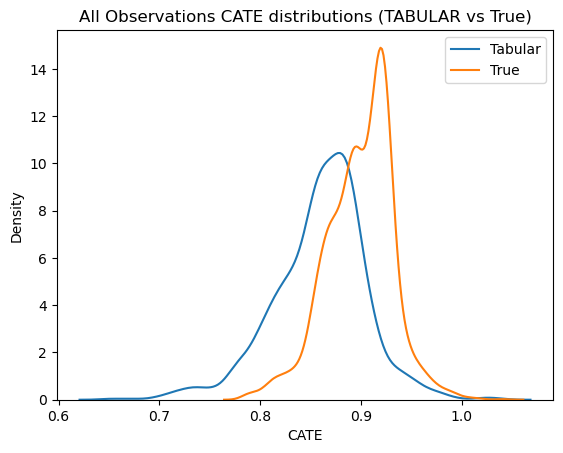

In [12]:
# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab['CATE'], label='Tabular')
sns.kdeplot(cate_true['theta_total'], label='True')
plt.legend(); plt.title("All Observations CATE distributions (TABULAR vs True)")
# plt.xlim(0, 3)
plt.show()

In [13]:
## ATE
print(f"The ATE in the training set from Tabular: {ate_tab['ate_train']}")
print(f"The ATE in the test set from Tabular: {ate_tab['ate_test']}")

The ATE in the training set from Tabular: 0.8595002262455143
The ATE in the test set from Tabular: 0.8595849825171167


In [14]:
## Adding CATE estimation back to the data
cate = cate_true.merge(
    cate_tab,
    on="scene_id",
    how="left",
)
cate.head(20)

,scene_id,theta_mean,theta_outgoing_mean,theta_total,dataset,CATE
0,1,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN
5,6,NaN,NaN,NaN,NaN,NaN
6,7,NaN,NaN,NaN,NaN,NaN
7,8,NaN,NaN,NaN,NaN,NaN
8,9,NaN,NaN,NaN,NaN,NaN
9,10,NaN,NaN,NaN,NaN,NaN


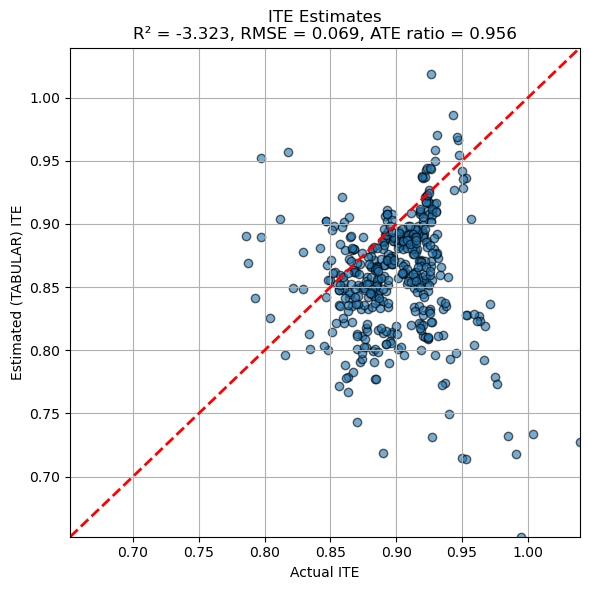

In [15]:
## Plotting the R2 for TABULAR CATE AND TRUE CATE
from sklearn.metrics import r2_score, mean_squared_error

cate = cate[cate['dataset'] == "test"]

# 2) Extract arrays
y_true = cate['theta_total'].to_numpy()
y_pred = cate['CATE'].to_numpy()

# 3) Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
ate_true = y_true.mean()
ate_pred = y_pred.mean()
ate_ratio = ate_pred / ate_true if ate_true != 0 else np.nan

# 4) Scatter plot actual vs. estimated
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
lo = min(y_true.min(), y_pred.min())
hi = max(y_true.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], "r--", lw=2)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.xlabel("Actual ITE")
plt.ylabel("Estimated (TABULAR) ITE")
plt.title(
    f"ITE Estimates\nR² = {r2:.3f}, RMSE = {rmse:.3f}, ATE ratio = {ate_ratio:.3f}"
)
plt.grid(True)
plt.tight_layout()
plt.show()

### IMAGE

In [31]:
# Removing NAs
clean_cols = COVS_IMAGE + [TREAT] + [OUTCOME]

# Check the number of drops
print(f"Number of observations: {img_df.shape[0]}")
img_df_clean = img_df.dropna(subset = clean_cols)
print(f"Number of observations: {img_df_clean.shape[0]}")

# split the (new) integer indices 0…n−1 into train/test
train_idx, test_idx = train_test_split(
    img_df_clean.index.values,
    test_size=0.2,        # 20% test
    random_state=42,      # for reproducibility
    shuffle=True
)

Number of observations: 3167
Number of observations: 2195


In [32]:
print(f"Training Set Size: {train_idx.shape}")
print(f"Test Set Size: {test_idx.shape}")

Training Set Size: (1756,)
Test Set Size: (439,)


In [33]:
# tabular-only
cate_img, ate_img, model_img = estimate_treatment_effect_tabular(
    df=img_df_clean,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS_IMAGE
)

/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.517e-02, tolerance: 2.423e-02
  model = cd_fast.enet_coordinate_descent(
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.238e-02, tolerance: 1.858e-02
  model = cd_fast.enet_coordinate_descent(
/home/sm79829/.conda/envs/ImageTRT/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

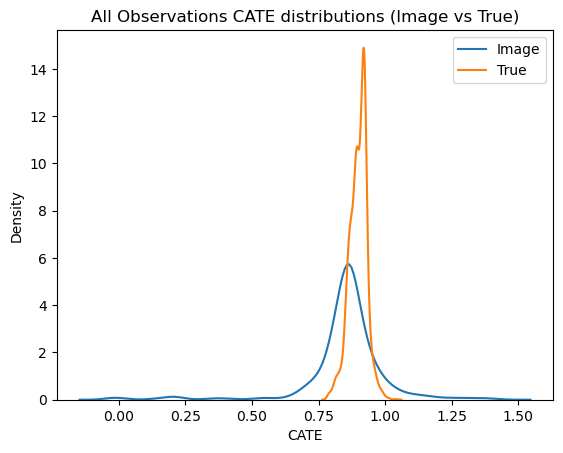

In [35]:
# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_img['CATE'], label='Image')
sns.kdeplot(cate_true['theta_total'], label='True')
plt.legend(); plt.title("All Observations CATE distributions (Image vs True)")
# plt.xlim(0, 3)
plt.show()

In [36]:
## ATE
print(f"The ATE in the training set from Tabular: {ate_img['ate_train']}")
print(f"The ATE in the test set from Tabular: {ate_img['ate_test']}")

The ATE in the training set from Tabular: 0.8523267193415883
The ATE in the test set from Tabular: 0.8614148217702118


In [37]:
## Adding CATE estimation back to the data
cate = cate_true.merge(
    cate_img,
    on="scene_id",
    how="left",
)
cate.head()

,scene_id,theta_mean,theta_outgoing_mean,theta_total,dataset,CATE
0,1,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN


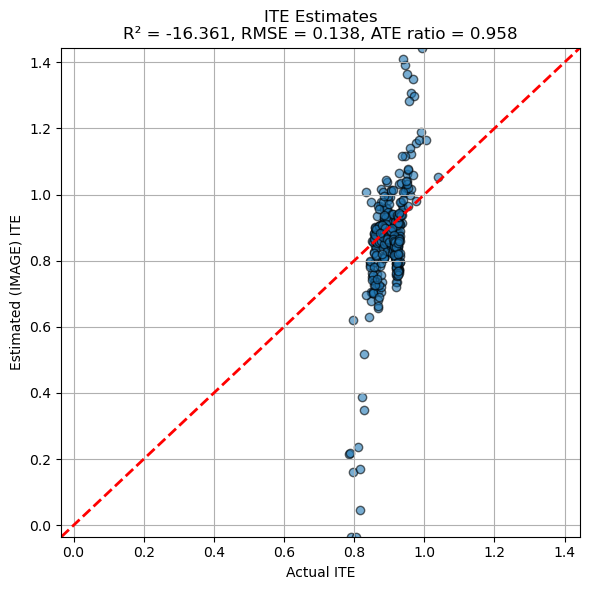

In [38]:
## Plotting the R2 for TABULAR CATE AND TRUE CATE
from sklearn.metrics import r2_score, mean_squared_error

cate = cate[cate['dataset'] == "test"]

# 2) Extract arrays
y_true = cate['theta_total'].to_numpy()
y_pred = cate['CATE'].to_numpy()

# 3) Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
ate_true = y_true.mean()
ate_pred = y_pred.mean()
ate_ratio = ate_pred / ate_true if ate_true != 0 else np.nan

# 4) Scatter plot actual vs. estimated
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
lo = min(y_true.min(), y_pred.min())
hi = max(y_true.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], "r--", lw=2)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.xlabel("Actual ITE")
plt.ylabel("Estimated (IMAGE) ITE")
plt.title(
    f"ITE Estimates\nR² = {r2:.3f}, RMSE = {rmse:.3f}, ATE ratio = {ate_ratio:.3f}"
)
plt.grid(True)
plt.tight_layout()
plt.show()

### IMAGE IN THE TREATMENT

In [40]:
# Removing NAs
clean_cols = COVS_IMAGE + [TREAT] + [OUTCOME]

# Check the number of drops
print(f"Number of observations: {img_df.shape[0]}")
img_df_clean = img_df.dropna(subset = clean_cols)
print(f"Number of observations: {img_df_clean.shape[0]}")

# split the (new) integer indices 0…n−1 into train/test
train_idx, test_idx = train_test_split(
    img_df_clean.index.values,
    test_size=0.2,        # 20% test
    random_state=42,      # for reproducibility
    shuffle=True
)

Number of observations: 3167
Number of observations: 2195


In [41]:
print(f"Training Set Size: {train_idx.shape}")
print(f"Test Set Size: {test_idx.shape}")

Training Set Size: (1756,)
Test Set Size: (439,)


In [42]:
# Building the Treatment Scalar
TREAT_IMAGE = sorted(list(set(COVS_IMAGE) - set(COVS)))

# Adding the image based to treatment
TREAT_IMAGE_ALL = [TREAT] + TREAT_IMAGE


In [43]:
# Copying the dataset
df = img_df_clean.copy()
df['T_vec'] = df[TREAT_IMAGE_ALL].values.tolist()

# Test/Train Data Split
train = df.loc[train_idx]
test = df.loc[test_idx]

X_tr = train[COVS].values
T_tr = np.vstack(train['T_vec'].values)
Y_tr = train[OUTCOME].values

X_te = test[COVS].values
T_te = np.vstack(test['T_vec'].values)
Y_te = test[OUTCOME].values


In [44]:
from econml.dml import CausalForestDML

# Fit model
cf = CausalForestDML(
    n_estimators = 500,
    random_state = 42,
)
cf.fit(Y_tr, T_tr, X = X_tr)

In [45]:
# Predict CATEs
cate_tr = cf.const_marginal_effect(X_tr)
cate_te = cf.const_marginal_effect(X_te)

# Summing CATEs
cate_tr_total = np.sum(cate_tr, axis = 1)
cate_te_total = np.sum(cate_te, axis = 1)

In [46]:
# Predict ATEs using proper baseline for multivariate treatment
ate_tr = cf.const_marginal_ate(X_tr)
ate_te = cf.const_marginal_ate(X_te)

# Summing the ATE
ate_tr_total = ate_tr.sum()
ate_te_total = ate_te.sum()

# Direct and Indirect ATE
ate_tr_direct = ate_tr[0]
ate_tr_indirect = ate_tr_total - ate_tr_direct
ate_te_direct = ate_tr[0]
ate_te_indirect = ate_te_total - ate_te_direct

# Print the ATEs
print(f"ATE Train Direct: {ate_tr_direct} & ATE Train Indirect: {ate_tr_indirect}")
print(f"ATE Test Direct: {ate_te_direct} & ATE Test Indirect: {ate_te_indirect}")

ATE Train Direct: 0.8142357083680334 & ATE Train Indirect: 0.0005540063169827691
ATE Test Direct: 0.8142357083680334 & ATE Test Indirect: -0.0142299773368747


In [47]:
# Collect results
df_tr = pd.DataFrame({
    'scene_id': train['scene_id'].values,
    'dataset': 'train',
    'CATE_wet': cate_tr_total
})
df_te = pd.DataFrame({
    'scene_id': test['scene_id'].values,
    'dataset': 'test',
    'CATE_wet': cate_te_total
})

# Creating Dataframe
cate_df = pd.concat([df_tr, df_te], ignore_index=True)
ate_dict = {'ate_train': ate_tr_total, 'ate_test': ate_te_total}

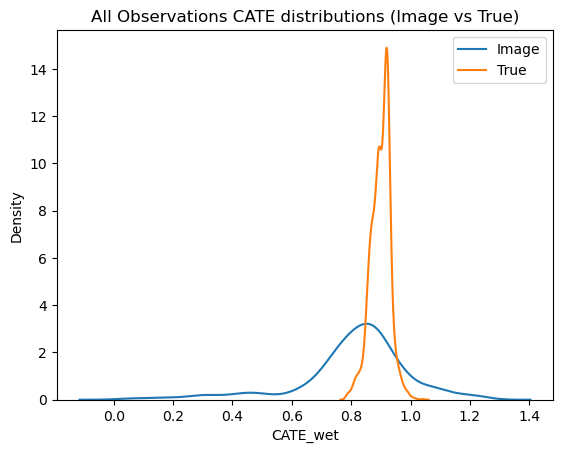

In [48]:
# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_df['CATE_wet'], label='Image')
sns.kdeplot(cate_true['theta_total'], label='True')
plt.legend(); plt.title("All Observations CATE distributions (Image vs True)")
# plt.xlim(0, 3)
plt.show()

In [49]:
## ATE
print(f"The ATE in the training set from Image Based Treatment: {ate_dict['ate_train']}")
print(f"The ATE in the test set from Image Based Treatment: {ate_dict['ate_test']}")

The ATE in the training set from Image Based Treatment: 0.8147897146850162
The ATE in the test set from Image Based Treatment: 0.8000057310311587


In [50]:
## Adding CATE estimation back to the data
cate = cate_true.merge(
    cate_df,
    on="scene_id",
    how="left",
)
cate.head()

,scene_id,theta_mean,theta_outgoing_mean,theta_total,dataset,CATE_wet
0,1,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN


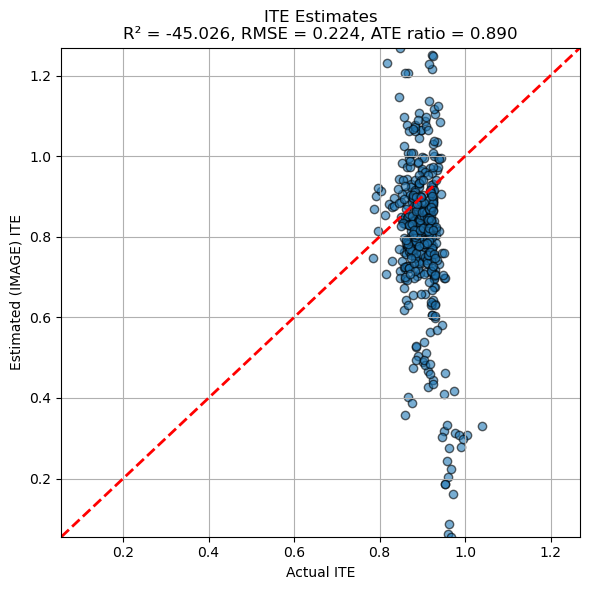

In [51]:
## Plotting the R2 for TABULAR CATE AND TRUE CATE
from sklearn.metrics import r2_score, mean_squared_error

cate = cate[cate['dataset'] == "test"]

# 2) Extract arrays
y_true = cate['theta_total'].to_numpy()
y_pred = cate['CATE_wet'].to_numpy()

# 3) Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
ate_true = y_true.mean()
ate_pred = y_pred.mean()
ate_ratio = ate_pred / ate_true if ate_true != 0 else np.nan

# 4) Scatter plot actual vs. estimated
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
lo = min(y_true.min(), y_pred.min())
hi = max(y_true.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], "r--", lw=2)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.xlabel("Actual ITE")
plt.ylabel("Estimated (IMAGE) ITE")
plt.title(
    f"ITE Estimates\nR² = {r2:.3f}, RMSE = {rmse:.3f}, ATE ratio = {ate_ratio:.3f}"
)
plt.grid(True)
plt.tight_layout()
plt.show()

## Linear Regression

In [5]:
# number of PC
n = 10

# load tables
tab_df     = pd.read_csv('features.csv')
# pca_wet    = pd.read_csv(f"stacked_wet_pca{n}.csv")
pca_wet = pd.read_csv("AE_embeddings/wet_ae_embeddings.csv")

# Looking at the Data
tab_df.head()

,scene_id,dem_mean,dem_std,cap_mean,cap_std,wet_mean,wet_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,...,ite_indirect_mean,ite_indirect_std,ite_total_mean,ite_total_std,theta_directXout_mean,theta_directXout_std,theta_outgoing_mean,theta_outgoing_std,theta_mean,theta_std
0,1,2.011171,1.077544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.376258,1.103501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3.807717,0.715921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.105153,0.670853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3.012371,0.481668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean']

# merge PCA back onto tab_df
img_df = tab_df.merge(pca_wet,  on='scene_id', how='left')

# COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
COVS_IMAGE = COVS + [f'emb_{i}' for i in range(128)]

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {COVS_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean']
Image Covariates: ['dem_mean', 'cap_mean', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31', 'emb_32', 'emb_33', 'emb_34', 'emb_35', 'emb_36', 'emb_37', 'emb_38', 'emb_39', 'emb_40', 'emb_41', 'emb_42', 'emb_43', 'emb_44', 'emb_45', 'emb_46', 'emb_47', 'emb_48', 'emb_49', 'emb_50', 'emb_51', 'emb_52', 'emb_53', 'emb_54', 'emb_55', 'emb_56', 'emb_57', 'emb_58', 'emb_59', 'emb_60', 'emb_61', 'emb_62', 'emb_63', 'emb_64', 'emb_65', 'emb_66', 'emb_67', 'emb_68', 'emb_69', 'emb_70', 'emb_71', 'emb_72', 'emb_73', 'emb_74', 'emb_75', 'emb_76', 'emb_77', 'emb_78', 'emb_79', 'emb_80', 'emb_81', 'emb_82', 'emb_83', 'emb_84', 'emb_85', 'emb_86', '

### TABULAR LINEAR REGRESSION

In [7]:
# Removing NAs
clean_cols = COVS + [TREAT] + [OUTCOME]

# Check the number of drops
print(f"Number of observations: {tab_df.shape[0]}")
tab_df_clean = tab_df.dropna(subset = clean_cols)
print(f"Number of observations: {tab_df_clean.shape[0]}")

Number of observations: 3167
Number of observations: 2195


In [8]:
import statsmodels.api as sm

Y = tab_df_clean[OUTCOME]

X_tab = [TREAT] + COVS

X_tab = sm.add_constant(tab_df_clean[X_tab])

model_tab = sm.OLS(Y, X_tab).fit()
print(model_tab.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.081e+05
Date:                Wed, 13 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:09:11   Log-Likelihood:                 4995.0
No. Observations:                2195   AIC:                            -9982.
Df Residuals:                    2191   BIC:                            -9959.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1265      0.001   -114.053      0.0

### IMAGE 

In [9]:
# Removing NAs
clean_cols = COVS + [TREAT] + [OUTCOME]

# Check the number of drops
print(f"Number of observations: {img_df.shape[0]}")
img_df_clean = img_df.dropna(subset = clean_cols)
print(f"Number of observations: {img_df_clean.shape[0]}")

Number of observations: 3167
Number of observations: 2195


In [10]:
# Adding T*PC Interactions Variables
for k in range(1, n+1):
    img_df_clean[f'T_PC{k}'] = img_df_clean['wet_mean'] * img_df_clean[f'PC{k}']

img_df_clean.head()

KeyError: 'PC1'

In [ ]:
# Making the Image based Covariates
interactions = [f'T_PC{k}' for k in range(1, n+1)]
x_img = [TREAT] + interactions + COVS
X_img = sm.add_constant(img_df_clean[x_img])

# Making Image Outcome
Y_img = img_df_clean[OUTCOME]
# Running the Model
model_img = sm.OLS(Y_img, X_img).fit()
print(model_img.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.150e+04
Date:                Sun, 27 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:16:22   Log-Likelihood:                 5105.5
No. Observations:                2195   AIC:                        -1.018e+04
Df Residuals:                    2181   BIC:                        -1.010e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1272      0.001   -114.970      0.0

In [ ]:
# 1) the main treat coefficient
β_t = model_img.params['wet_mean']

# 2) the interaction coefficients
inter_cols = [f'T_PC{k}' for k in range(1, n+1)]
β_int = model_img.params[inter_cols].sum()

# 3) total “average” treatment effect per unit change in wet_mean when all PCs = 1
β_total = β_t + β_int

print("Estimated ATE components from image‐augmented regression (Not in Covariates):")
print(f"β_treatment = {β_t:.4f}")
print(f"sum of β_{ '{'}T\\_PC1…T\\_PC50{'}'} = {β_int:.4f}")
print(f"β_treatment + ∑β_interactions = {β_total:.4f}")

Estimated ATE components from image‐augmented regression (Not in Covariates):
β_treatment = 0.9125
sum of β_{T\_PC1…T\_PC50} = -0.0015
β_treatment + ∑β_interactions = 0.9110


### IMAGE 2

In [ ]:
# Making the Image based Covariates
x_img2 = [TREAT] + interactions + COVS_IMAGE
X_img2 = sm.add_constant(img_df_clean[x_img])

# Making Image Outcome
Y_img2 = img_df_clean[OUTCOME]

# Running the Model
model_img2 = sm.OLS(Y_img2, X_img2).fit()
print(model_img2.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.150e+04
Date:                Sun, 27 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:16:34   Log-Likelihood:                 5105.5
No. Observations:                2195   AIC:                        -1.018e+04
Df Residuals:                    2181   BIC:                        -1.010e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1272      0.001   -114.970      0.0

In [ ]:
# 1) the main treat coefficient
β_t2 = model_img2.params['wet_mean']

# 2) the interaction coefficients
inter_cols = [f'T_PC{k}' for k in range(1, n+1)]
β_int2 = model_img2.params[inter_cols].sum()

# 3) total “average” treatment effect per unit change in wet_mean when all PCs = 1
β_total2 = β_t2 + β_int2

print("Estimated ATE components from image‐augmented regression (Not in Covariates):")
print(f"β_treatment = {β_t:.4f}")
print(f"sum of β_{ '{'}T\\_PC1…T\\_PC50{'}'} = {β_int:.4f}")
print(f"β_treatment + ∑β_interactions = {β_total:.4f}")

Estimated ATE components from image‐augmented regression (Not in Covariates):
β_treatment = 0.9125
sum of β_{T\_PC1…T\_PC50} = -0.0015
β_treatment + ∑β_interactions = 0.9110


In [ ]:
### TRUE ATE

print("TRUE Direct ATE:", np.mean(tab_df['theta_mean']))
print("TRUE Indirect ATE:", np.mean(tab_df['theta_outgoing_mean']))
print("TRUE Total ATE:", np.mean(tab_df['theta_mean'] + tab_df['theta_outgoing_mean']))

TRUE Direct ATE: 0.6019562665250042
TRUE Indirect ATE: 0.297015114427716
TRUE Total ATE: 0.8989713809527202


### AutoEncoders LINEAR REGRESSION

In [78]:
# load tables
tab_df     = pd.read_csv('features.csv')
ae_wet = pd.read_csv("AE_embeddings/wet_ae_embeddings_16.csv")

# Looking at the Data
tab_df.head()

# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
COVS = ['dem_mean', 'cap_mean']

# merge AE Embeddings back onto tab_df
img_df = tab_df.merge(ae_wet,  on='scene_id', how='left')

# COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
Emb_IMAGE = [f'emb_{i}' for i in range(16)]

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {Emb_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean']
Image Covariates: ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15']


In [79]:
# Removing NAs
clean_cols = Emb_IMAGE + [TREAT] + [OUTCOME]

# Check the number of drops
print(f"Number of observations: {img_df.shape[0]}")
img_df_clean = img_df.dropna(subset = clean_cols)
print(f"Number of observations: {img_df_clean.shape[0]}")
img_df_clean.head()

Number of observations: 3167
Number of observations: 2195


,scene_id,dem_mean,dem_std,cap_mean,cap_std,wet_mean,wet_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,...,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15
70,71,-0.574050,0.401285,-0.085230,0.127414,0.721329,0.448345,0.127926,0.088466,0.467215,...,-30.407032,5.611097,49.456207,43.151806,-23.254047,0.958351,16.469240,26.226709,8.767120,-55.938141
71,72,-0.821595,0.083633,-0.083978,0.106208,0.999954,0.006766,0.141342,0.101484,0.652158,...,-31.261389,33.390198,36.137379,46.439659,29.643393,9.282661,-31.905161,-25.135563,-30.297104,-12.167266
72,73,-0.828738,0.097527,-0.102350,0.057079,0.999954,0.006766,0.140082,0.085238,0.665800,...,-31.261389,33.390198,36.137379,46.439659,29.643393,9.282661,-31.905161,-25.135563,-30.297104,-12.167266
73,74,-0.826534,0.121183,-0.101190,0.063207,0.999466,0.023104,0.170093,0.092583,0.628838,...,-31.292055,33.350292,36.310505,46.455711,29.643950,9.394843,-32.015915,-25.001192,-30.266972,-11.955605
146,148,-0.274208,0.393648,-0.071385,0.125257,0.404541,0.490803,0.117172,0.093233,0.254070,...,6.565583,-21.174019,-43.497181,-31.526154,-3.748097,37.721096,9.972792,-24.446571,-18.739634,-29.730148


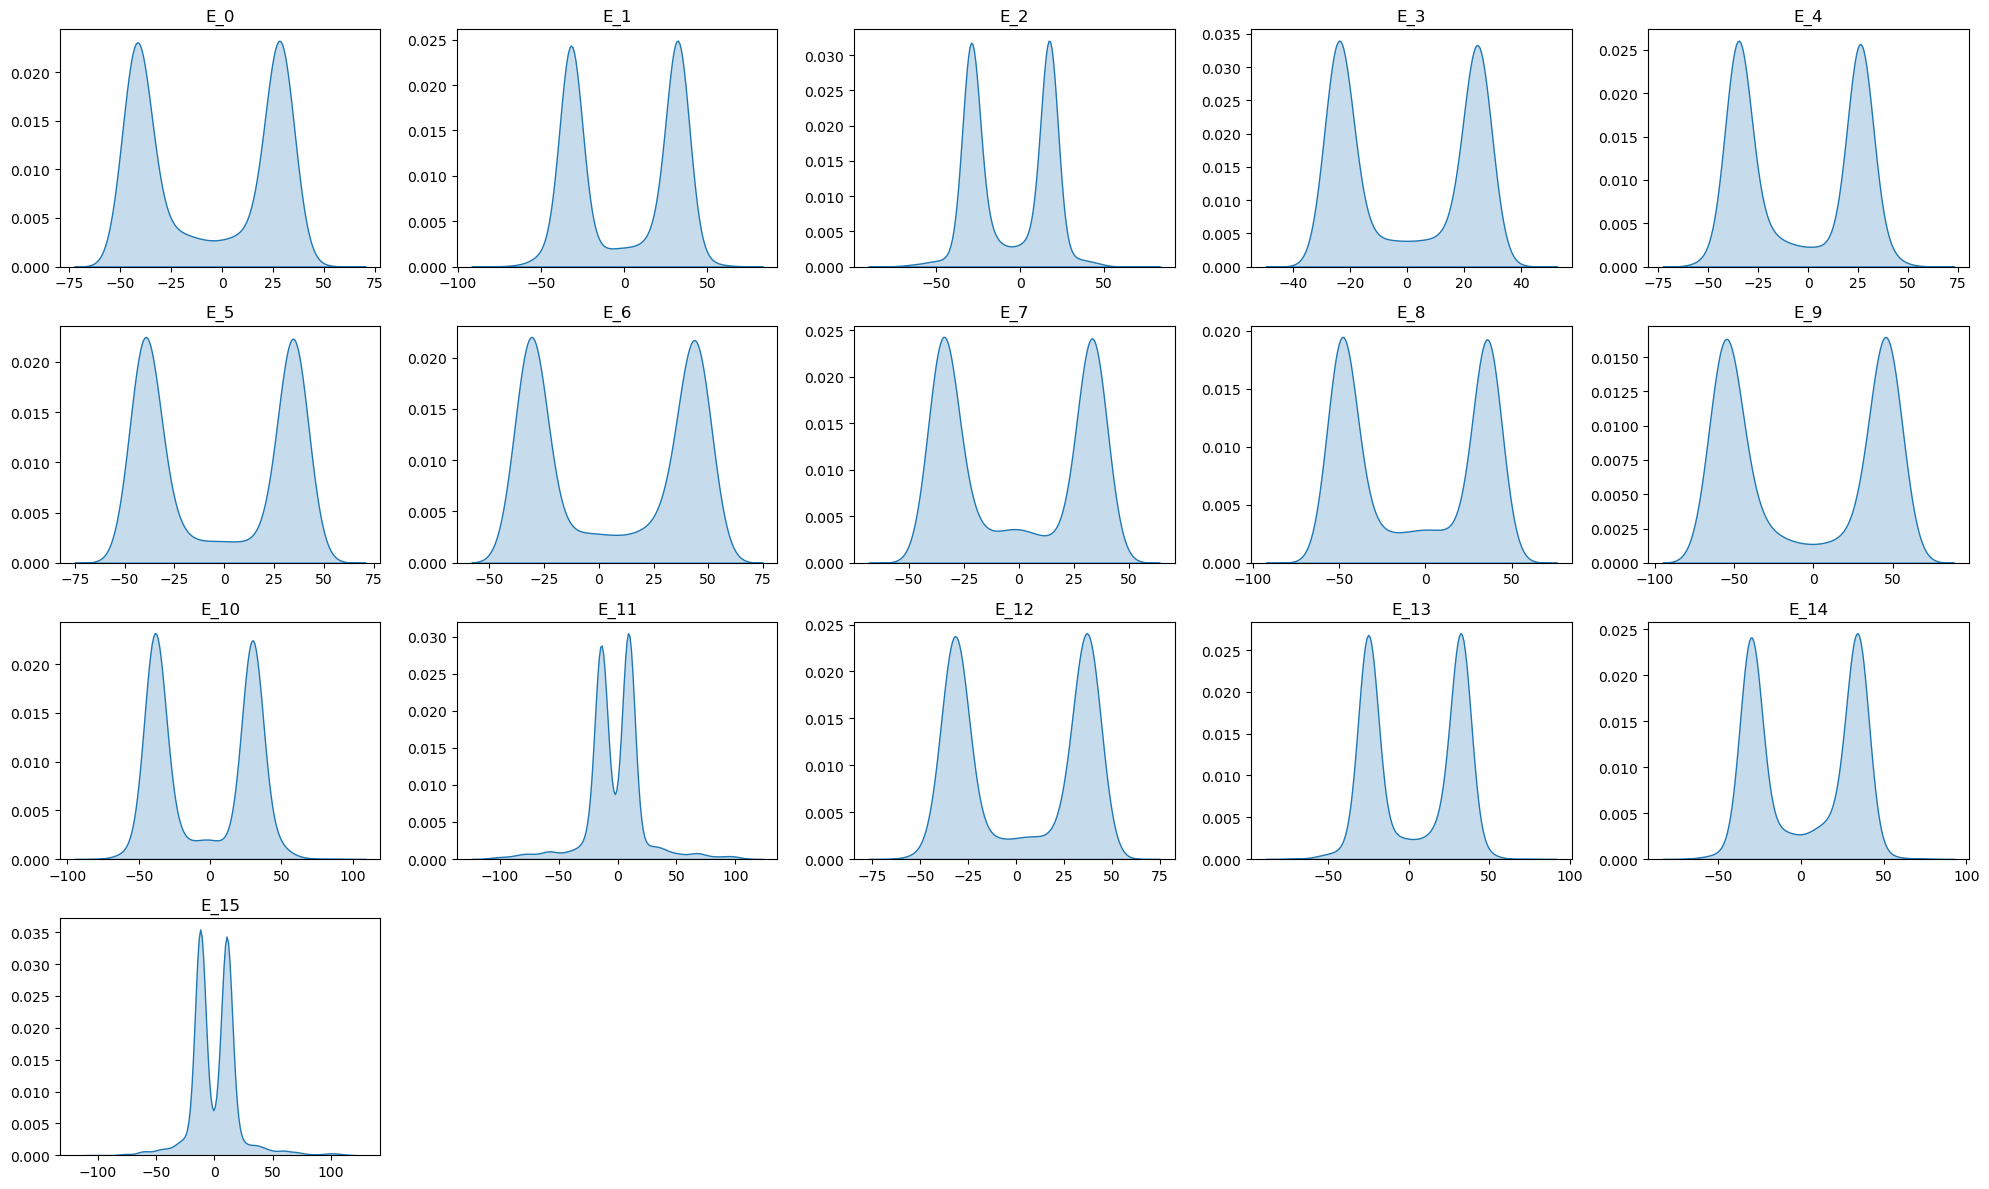

In [80]:
import random
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0) pick the embedding columns
emb_cols = [c for c in img_df_clean.columns if c.startswith('emb_')]
k = min(30, len(emb_cols))

# reproducible random sample
random.seed(42)
sel = random.sample(emb_cols, k=k)

# sort by numeric index so titles are sensible
sel = sorted(sel, key=lambda s: int(s.split('_')[1]))

# 1) grid shape
cols = 5
rows = math.ceil(k / cols)

plt.figure(figsize=(4*cols, 3*rows))
for idx, col in enumerate(sel, start=1):
    plt.subplot(rows, cols, idx)
    sns.kdeplot(img_df_clean[col].dropna(), fill=True)
    emb_idx = int(col.split('_')[1])
    plt.title(f"E_{emb_idx}")
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()


In [81]:
import statsmodels.api as sm

# Build Model
Y = img_df_clean[OUTCOME].values
Tbar = img_df_clean['wet_mean']
Xtab = img_df_clean[COVS]
Ef = img_df_clean[Emb_IMAGE]

# Fit Y ~ T + controls + embeddings (HC3) ---
design = pd.concat([Xtab, Tbar.rename('Tbar'), Ef], axis=1)
design = sm.add_constant(design)
model  = sm.OLS(Y, design).fit(cov_type="HC3")

print(model.summary().tables[1])      # short coef table

# --- 3) Mediation pieces ---
# Direct effect (coefficient on Tbar in the full model)
DE = model.params['Tbar']

# γ_j: how each embedding dimension moves with T (E = γ*T + error)
T_mat = Tbar.values.reshape(-1, 1)            # (n,1)
gammas = np.linalg.lstsq(T_mat, Ef.values, rcond=None)[0].flatten()  # (K,)

# β_E: effect of each embedding on Y (from the full model)
beta_E = model.params[Emb_IMAGE].values        # (K,)

# Indirect and Total
IE = float(np.dot(gammas, beta_E))
TE = float(DE + IE)

print("\n--- Effects (per 1-unit increase in T) ---")
print(f"Direct  (β_T): {DE:.4f}")
print(f"Indirect (Σ γ_j·β_Ej): {IE:.4f}")
print(f"Total           : {TE:.4f}")


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1788      0.020     -8.858      0.000      -0.218      -0.139
dem_mean       0.0646      0.001     56.310      0.000       0.062       0.067
cap_mean      -0.1844      0.011    -17.547      0.000      -0.205      -0.164
Tbar           0.7326      0.040     18.444      0.000       0.655       0.810
emb_0         -0.0004      0.001     -0.709      0.478      -0.001       0.001
emb_1         -0.0003      0.000     -0.855      0.392      -0.001       0.000
emb_2          0.0009      0.000      2.052      0.040    3.81e-05       0.002
emb_3          0.0007      0.000      1.510      0.131      -0.000       0.002
emb_4          0.0006      0.001      1.151      0.250      -0.000       0.002
emb_5          0.0002      0.000      0.378      0.705      -0.001       0.001
emb_6          0.0014      0.001      1.906      0.0

In [42]:
print(tab_df['theta_mean'].mean())
print(tab_df['theta_outgoing_mean'].mean())
print(tab_df['theta_mean'].mean() + tab_df['theta_outgoing_mean'].mean())

0.6019562665250042
0.029701511446065122
0.6316577779710694


## PLS Models

In [40]:
# number of PC
n = 512

# load tables
tab_df     = pd.read_csv('features.csv')
# pca_wet    = pd.read_csv(f"wet_pca{n}.csv")
pca_wet = pd.read_csv("stacked_embeddings.csv")

# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean']

# merge PCA back onto tab_df
img_df = tab_df.merge(pca_wet,  on='scene_id', how='left')

# COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
COVS_IMAGE  = COVS + [f'emb_{i}' for i in range(n)]

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {COVS_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean']
Image Covariates: ['dem_mean', 'cap_mean', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31', 'emb_32', 'emb_33', 'emb_34', 'emb_35', 'emb_36', 'emb_37', 'emb_38', 'emb_39', 'emb_40', 'emb_41', 'emb_42', 'emb_43', 'emb_44', 'emb_45', 'emb_46', 'emb_47', 'emb_48', 'emb_49', 'emb_50', 'emb_51', 'emb_52', 'emb_53', 'emb_54', 'emb_55', 'emb_56', 'emb_57', 'emb_58', 'emb_59', 'emb_60', 'emb_61', 'emb_62', 'emb_63', 'emb_64', 'emb_65', 'emb_66', 'emb_67', 'emb_68', 'emb_69', 'emb_70', 'emb_71', 'emb_72', 'emb_73', 'emb_74', 'emb_75', 'emb_76', 'emb_77', 'emb_78', 'emb_79', 'emb_80', 'emb_81', 'emb_82', 'emb_83', 'emb_84', 'emb_85', 'emb_86', '

In [41]:
# Removing NAs
clean_cols = COVS_IMAGE + [TREAT] + [OUTCOME]

# Check the number of drops
print(f"Number of observations: {img_df.shape[0]}")
img_df_clean = img_df.dropna(subset = clean_cols)
print(f"Number of observations: {img_df_clean.shape[0]}")

# split the (new) integer indices 0…n−1 into train/test
train_idx, test_idx = train_test_split(
    img_df_clean.index.values,
    test_size=0.2,        # 20% test
    random_state=42,      # for reproducibility
    shuffle=True
)

Number of observations: 3167
Number of observations: 2195


In [42]:
from sklearn.ensemble import RandomForestRegressor

E_raw = img_df_clean.filter(like = "emb_").to_numpy()
Tbar = img_df_clean['wet_mean']
Y = img_df_clean[OUTCOME].to_numpy()

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# 1-a: orthogonalise E_raw vs. T̄
# — make sure Tbar is a NumPy column vector
Tbar_np = Tbar.to_numpy().reshape(-1, 1)
# reg = LinearRegression().fit(Tbar_np, E_raw)
# E_resid = E_raw - reg.predict(Tbar_np)   # (n_scenes, 2048)

def effect_estimation(K):
    
    # 1-b: supervised PLS reduction of E_resid on Y
    # build a simple pipeline, but call fit/transform explicitly
    pls_pipe = make_pipeline(
        StandardScaler(), 
        PLSRegression(n_components=K)
    )

    # train on (E_resid, Y)
    # pls_pipe.fit(E_resid, Y)
    pls_pipe.fit(E_raw, Y)

    # then transform to get your (n_scenes, K) factor matrix
    # E_factors = pls_pipe.transform(E_resid)
    E_factors = pls_pipe.transform(E_raw)

    X = img_df_clean[['cap_mean','dem_mean']]
    cols_f = [f"E_{i}" for i in range(K)]
    df_factors = pd.DataFrame(E_factors, columns=cols_f, index=img_df_clean.index)
    design = pd.concat([X, Tbar.rename("Tbar"), df_factors], axis=1)
    import statsmodels.api as sm
    design = sm.add_constant(design)

    model = sm.OLS(Y, design).fit(cov_type="HC3")
    # print(model.summary())

    ####### Models
    # 1) Extract the direct effect
    DE = model.params['Tbar']

    # 2) Estimate the γ’s: slopes from E_j on Tbar
    T_mat = Tbar.values.reshape(-1, 1)                   # shape (n,1)
    # least‐squares in one shot: returns a (1 × 20) array of γ’s
    gammas = np.linalg.lstsq(T_mat, df_factors.values, rcond=None)[0].flatten()

    # 3) Extract the β_E’s
    beta_E = model.params[[f"E_{i}" for i in range(K)]].values

    # 4) Compute the indirect effect
    IE = np.dot(gammas, beta_E)

    # 5) Total effect
    TE = DE + IE
    print(f"------------------------- K = {K} -------------------------")
    print(f"Direct Effect (β_T): {DE:.4f}")
    print(f"Indirect Effect (Σ γ_j·β_Ej): {IE:.4f}")
    print(f"Total Effect: {TE:.4f}")

    return df_factors


In [24]:
E_factors = effect_estimation(20)
E_factors

------------------------- K = 20 -------------------------
Direct Effect (β_T): 0.7104
Indirect Effect (Σ γ_j·β_Ej): 0.0195
Total Effect: 0.7299


,E_0,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12,E_13,E_14,E_15,E_16,E_17,E_18,E_19
70,2.099826,-10.601343,3.705305,3.759379,3.339171,3.864196,-5.575270,3.179588,2.800127,-1.294298,-6.450651,1.706746,-0.579898,-0.363282,-2.480647,2.518128,2.405022,3.542278,3.000143,2.925583
71,-7.118226,-1.813664,-4.612997,-0.419304,-3.990479,2.367280,3.541136,-1.941188,6.675925,-2.570676,-0.243406,0.314120,-0.041743,-3.088735,-0.108354,1.017513,-2.446713,0.004212,1.832550,-1.173560
72,-7.085754,-4.360286,-8.306550,-3.632980,3.176306,-0.643096,2.350716,-1.689581,11.809291,-0.272867,2.949230,-1.142997,1.712322,-0.811509,0.034194,-1.313705,-2.075254,2.023531,1.222542,-3.266609
73,-4.998385,-1.942101,-2.653071,2.460500,-0.850035,0.204693,2.558085,-2.758824,7.782449,-1.623843,1.697563,0.515662,0.624015,-4.520962,1.306312,2.352001,1.264161,-2.284999,1.893929,-0.787327
146,3.968736,-8.614890,5.703014,-2.345692,-4.571572,-2.495524,-1.750420,3.895898,2.175947,-4.600141,-1.023948,0.792476,-2.249982,0.555320,-2.539961,2.278333,0.954523,1.925589,3.020604,0.529169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,-2.833193,-0.299644,-8.214202,1.912722,3.592961,1.494608,-2.188765,-2.756454,-3.576364,-3.904218,0.502507,-3.312853,-2.333572,2.294217,-0.615379,1.239415,-0.219715,-1.570649,0.027119,-1.008308
3086,-5.835722,3.466095,-1.793666,4.959038,3.093509,3.556195,-2.465599,-1.192572,-1.989966,-2.412313,-1.195298,-0.258306,-2.247609,-1.376689,2.048279,2.449510,-0.586806,2.032794,1.848870,-1.939391
3087,-4.659143,2.281428,-3.088920,5.791160,3.223293,-0.329406,-2.149564,0.312704,-3.838983,-5.481037,3.913581,-1.148419,0.595903,-0.216477,2.227017,0.361121,-5.023317,0.701099,-0.724116,-0.236359
3088,-5.163967,0.817114,-5.934528,2.678534,2.493431,0.306207,0.306489,0.572200,-4.497122,-2.982065,-0.744557,-1.827467,-1.712007,1.980041,1.241958,1.725863,-2.330205,-1.267927,1.414728,-1.124661


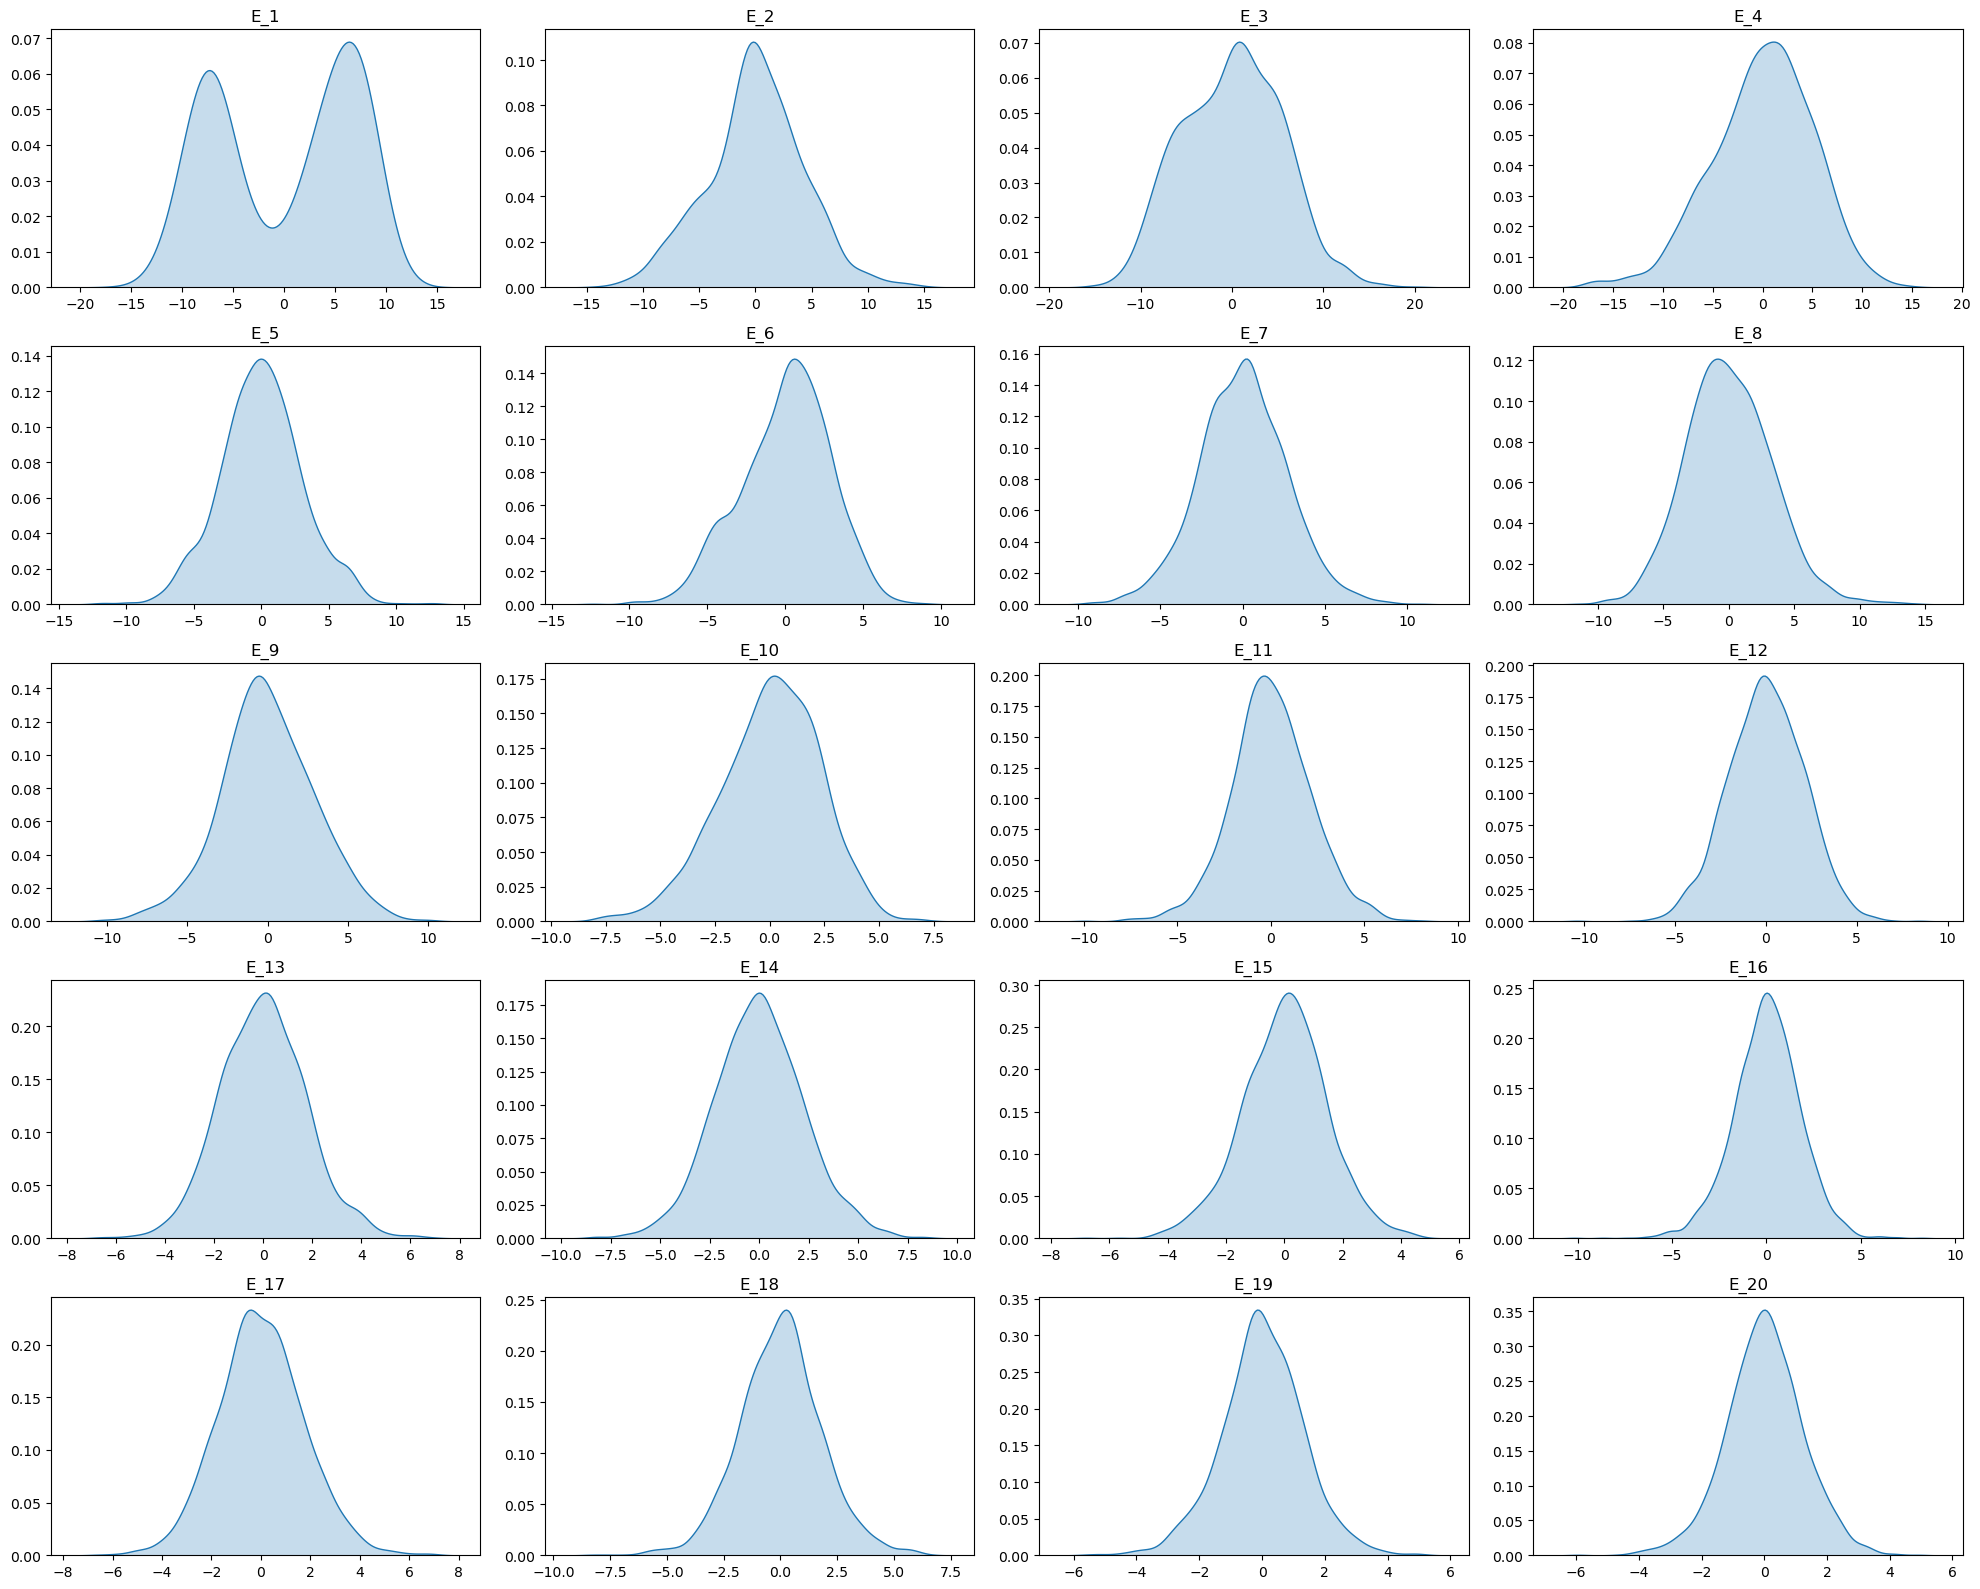

In [24]:
## Plot the Embeddings for E_1 to E_20
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
for i in range(1, 21):
    plt.subplot(5, 4, i)
    sns.kdeplot(E_factors[f'E_{i-1}'], fill=True)
    plt.title(f'E_{i}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

In [44]:
list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

for K in list:
    effect_estimation(K)


------------------------- K = 5 -------------------------
Direct Effect (β_T): 0.7510
Indirect Effect (Σ γ_j·β_Ej): 0.0039
Total Effect: 0.7549
------------------------- K = 10 -------------------------
Direct Effect (β_T): 0.7176
Indirect Effect (Σ γ_j·β_Ej): 0.0166
Total Effect: 0.7341
------------------------- K = 15 -------------------------
Direct Effect (β_T): 0.7248
Indirect Effect (Σ γ_j·β_Ej): 0.0134
Total Effect: 0.7382
------------------------- K = 20 -------------------------
Direct Effect (β_T): 0.7167
Indirect Effect (Σ γ_j·β_Ej): 0.0170
Total Effect: 0.7336
------------------------- K = 25 -------------------------
Direct Effect (β_T): 0.7132
Indirect Effect (Σ γ_j·β_Ej): 0.0175
Total Effect: 0.7307
------------------------- K = 30 -------------------------
Direct Effect (β_T): 0.7087
Indirect Effect (Σ γ_j·β_Ej): 0.0191
Total Effect: 0.7278
------------------------- K = 35 -------------------------
Direct Effect (β_T): 0.7087
Indirect Effect (Σ γ_j·β_Ej): 0.0192
Total E

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def effect_estimation_tworesonds(K):
    # stack Y and T into a two‐column array
    YT = np.column_stack([Y, Tbar.values.reshape(-1, 1)])  # shape (n,2)

    pls2_pipe = make_pipeline(
        StandardScaler(),
        PLSRegression(n_components=K)
    )

    # fit so components covary with both Y and T
    pls2_pipe.fit(E_raw, YT)
    E_factors = pls2_pipe.transform(E_raw)                # (n, K)

    # 3) Build DataFrame of factors + controls + treatment
    # ---------------------------------------------------
    X = img_df_clean[['cap_mean', 'dem_mean']]
    cols_f = [f"E_{i}" for i in range(K)]
    df_factors = pd.DataFrame(E_factors, columns=cols_f, index=img_df_clean.index)

    design = pd.concat([X, Tbar.rename("Tbar"), df_factors], axis=1)
    design = sm.add_constant(design)

    # 4) Fit the full OLS
    # ---------------------------------------------------
    model = sm.OLS(Y, design).fit(cov_type="HC3")
    # print(model.summary())

    # 5) Decompose into direct, indirect, total
    # ---------------------------------------------------
    # Direct effect:
    DE = model.params['Tbar']

    # γ_j: how each factor responds to Tbar
    T_mat = Tbar.values.reshape(-1, 1)                   # (n,1)
    gammas = np.linalg.lstsq(T_mat, E_factors, rcond=None)[0].flatten()

    # β_E: factor → Y
    beta_E = model.params[cols_f].values

    # Indirect effect = Σ γ_j · β_Ej
    IE = np.dot(gammas, beta_E)

    # Total effect = direct + indirect
    TE = DE + IE

    print(f"------------------------- K = {K} -------------------------")
    print(f"Direct Effect:   {DE:.4f}")
    print(f"Indirect Effect: {IE:.4f}")
    print(f"Total Effect:    {TE:.4f}")


In [39]:
list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

for K in list:
    effect_estimation_tworesonds(K)


------------------------- K = 5 -------------------------
Direct Effect:   0.8971
Indirect Effect: 0.0055
Total Effect:    0.9027
------------------------- K = 10 -------------------------
Direct Effect:   0.8669
Indirect Effect: 0.0181
Total Effect:    0.8850
------------------------- K = 15 -------------------------
Direct Effect:   0.8225
Indirect Effect: 0.0389
Total Effect:    0.8615
------------------------- K = 20 -------------------------
Direct Effect:   0.8347
Indirect Effect: 0.0329
Total Effect:    0.8676
------------------------- K = 25 -------------------------
Direct Effect:   0.8158
Indirect Effect: 0.0411
Total Effect:    0.8569
------------------------- K = 30 -------------------------
Direct Effect:   0.8237
Indirect Effect: 0.0373
Total Effect:    0.8610
------------------------- K = 35 -------------------------
Direct Effect:   0.8576
Indirect Effect: 0.0211
Total Effect:    0.8787
------------------------- K = 40 -------------------------
Direct Effect:   0.8530
I